# Trafik Kazalarından Yaralanma Şiddetinin Tahmini

## Proje Amacı:
Chicago’da meydana gelen trafik kazalarıyla ilgili bilgileri inceleyerek bir kazada insanların ne kadar yaralanabileceğini önceden tahmin edebilmektir. Elimizde, her kaza için hava durumu, yol koşulları, kazanın gündüz mü gece mi yaşandığı, yolun kaç şeritli olduğu, kazanın bir kavşakta gerçekleşip gerçekleşmediği, hız sınırı, kaç aracın karıştığı ve kazanın türü gibi birçok detay bulunmaktadır. Bu bilgiler kullanılarak “Bu kazada yaralanma hafif mi olurdu, ağır mı olurdu, yoksa hiç yaralanma olmaz mıydı?” sorusuna cevap aranmaktadır. Böyle bir çalışma sayesinde kazaların sonuçlarını önceden tahmin etmek, tehlikeli durumları daha iyi anlamak ve ileride benzer şartlar oluştuğunda ne tür sonuçların ortaya çıkabileceğine dair daha güçlü öngörüler oluşturmak mümkündür. Bunun sonucunda güvenliği artırmaya yönelik daha doğru kararlar alınabilir; örneğin belirli bölgelerde hız sınırının düzenlenmesi, ışıklandırmanın iyileştirilmesi veya yol koşullarının kazalara etkisinin daha iyi anlaşılması gibi önemli çıkarımlar sağlanabilir.

### 1- Kütüphanelerin Tanımlanması:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
RNG = 42
np.random.seed(RNG)

### 2- Veri yükleme:

In [2]:
# ==========================================
# 1. VERİ YÜKLEME
# ==========================================
print("--- Veri Yükleniyor ---")
df = pd.read_csv("Traffic_Crashes.csv")

--- Veri Yükleniyor ---


### 3- Veri İnceleme (Exploratory Review):
Bu aşamada elimizdeki veri setini genel hatlarıyla tanımayı amaçlıyoruz. Bu yaptığımız verinin içinde neler olduğunu anlamak, hangi tür bilgilerin yer aldığını görmek, hangi sütunların önemli olabileceğini fark etmek için yapılan ilk gözlemdir. Bu bölümde veri setinin büyüklüğüne bakılır; yani kaç satır ve kaç sütun olduğu görülür. Her bir sütunun ne anlama geldiği anlaşılmaya çalışılır. Eksik bilgi olup olmadığına, tekrar eden satırlar bulunup bulunmadığına ve verilerin türlerinin doğru şekilde tanımlanıp tanımlanmadığına bakılır. Bu inceleme, ileride yapılacak tüm işlemler için bir temel oluşturur. Çünkü veriyi yeterince tanımazsak, doğru bir hazırlık, analiz veya modelleme yapamayız. Bu aşama sayesinde veri setinin yapısı, sorunları ve potansiyel kullanım şekilleri hakkında genel bir fikir sahibi oluruz.

In [3]:
print("Orijinal veri boyutu:", df.shape)
print("Sütun sayısı:", len(df.columns))

Orijinal veri boyutu: (300000, 48)
Sütun sayısı: 48


In [4]:
# İlk 5 satırı göster
df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,98df5755b18bc25a67163bb832c0fd2b72c41631ef6e7d...,NaN,02/03/2025 06:30:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,UNKNOWN,UNKNOWN,PEDESTRIAN,DIVIDED - W/MEDIAN (NOT RAISED),...,1.0,0.0,1.0,0.0,6,2,2,41.904354,-87.721531,POINT (-87.721531234586 41.904353607338)
1,4e85802a19266b7c4c848561724da842d34a2509a4d931...,NaN,06/16/2022 01:50:00 AM,30,NO CONTROLS,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,ONE-WAY,...,1.0,0.0,0.0,0.0,1,5,6,41.800640,-87.620846,POINT (-87.620846187015 41.800640445503)
2,d747392bff241c36c7ecbc171143947f6b93896a72a4ce...,NaN,01/19/2024 06:11:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,FREEZING RAIN/DRIZZLE,DAYLIGHT,REAR END,CENTER TURN LANE,...,1.0,0.0,1.0,0.0,18,6,1,41.659126,-87.559433,POINT (-87.559432741943 41.659126189932)
3,54aa7076c5ff7e2667d07268186d95064cad67ffa84e89...,NaN,02/01/2025 01:00:00 PM,30,NO CONTROLS,NO CONTROLS,UNKNOWN,DAYLIGHT,REAR TO SIDE,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,2.0,0.0,13,7,2,41.705506,-87.535139,POINT (-87.535139453239 41.7055064825)
4,ac3f58b20d6ca95846e085b053618467d967c51f68d2c1...,NaN,07/14/2025 08:45:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,0.0,0.0,2.0,0.0,8,2,7,41.850620,-87.632113,POINT (-87.632112683668 41.850620317342)


In [5]:
# Veri yapısı bilgisi
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                300000 non-null  object 
 1   CRASH_DATE_EST_I               19194 non-null   object 
 2   CRASH_DATE                     300000 non-null  object 
 3   POSTED_SPEED_LIMIT             300000 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         300000 non-null  object 
 5   DEVICE_CONDITION               300000 non-null  object 
 6   WEATHER_CONDITION              300000 non-null  object 
 7   LIGHTING_CONDITION             300000 non-null  object 
 8   FIRST_CRASH_TYPE               300000 non-null  object 
 9   TRAFFICWAY_TYPE                300000 non-null  object 
 10  LANE_CNT                       56674 non-null   float64
 11  ALIGNMENT                      300000 non-null  object 
 12  ROADWAY_SURFACE_COND          

In [6]:
# Veri tipi özet
print("\n--- Veri tipi özet ---")
print(df.dtypes.value_counts())


--- Veri tipi özet ---
object     31
float64    11
int64       6
Name: count, dtype: int64


### 4- Mantıksal Tutarlılık (Sanity Check)
Bu adımda veri setindeki mantıksız veya fiziksel olarak mümkün olmayan değerler kontrol edilir. Özellikle hız sınırı (POSTED_SPEED_LIMIT) değişkeninde 0–90 aralığı dışındaki değerler hatalı kabul edilerek veri setinden çıkarılır. Böylece model eğitiminde veri kalitesi artırılmış olur.

In [7]:
# ------------------------------------------
# ### ADIM 3: MANTIKSAL TUTARLILIK KONTROLÜ (SANITY CHECK)
# ------------------------------------------
# Sayısal verilerdeki imkansız değerleri temizliyoruz.
# Örneğin: Hız sınırı negatif veya 100 mph üzeri olamaz (şehir içi).
print("\n--- Mantıksal Kontroller Yapılıyor ---")

# Hız sınırı kontrolü (0 ile 90 arası makul kabul edildi)
hatali_hiz_sayisi = df[(df['POSTED_SPEED_LIMIT'] < 0) | (df['POSTED_SPEED_LIMIT'] > 90)].shape[0]
if hatali_hiz_sayisi > 0:
    print(f"{hatali_hiz_sayisi} adet mantıksız hız sınırı değeri tespit edildi ve temizleniyor.")
    df = df[(df['POSTED_SPEED_LIMIT'] >= 0) & (df['POSTED_SPEED_LIMIT'] <= 90)]
else:
    print("Hız sınırları mantıksal aralıkta.")
# ------------------------------------------


--- Mantıksal Kontroller Yapılıyor ---
19 adet mantıksız hız sınırı değeri tespit edildi ve temizleniyor.


### 5-Eksik Değer Analizi
Bu bölümde veri setindeki her sütun için eksik değer sayısı ve yüzde oranı hesaplanır. Eksik değerler en yüksekten düşüğe doğru sıralanarak hangi değişkenlerde yoğun boşluk olduğunu hızlıca görmemizi sağlar. Bu analiz, sonradan uygulanacak doldurma, silme veya dönüştürme işlemleri için temel oluşturur.

In [8]:
# Eksik değer analiz tablosu
eksik_sayisi = df.isnull().sum()
eksik_yuzdesi = (eksik_sayisi / len(df)) * 100

eksik_df = pd.DataFrame({
    'eksik_sayisi': eksik_sayisi,
    'eksik_yuzdesi': eksik_yuzdesi
}).sort_values(by='eksik_yuzdesi', ascending=False)

eksik_df.head(50)

,eksik_sayisi,eksik_yuzdesi
WORKERS_PRESENT_I,299554,99.857658
WORK_ZONE_TYPE,298689,99.569306
WORK_ZONE_I,298223,99.413963
DOORING_I,297618,99.212283
PHOTOS_TAKEN_I,295278,98.432234
STATEMENTS_TAKEN_I,289818,96.612119
NOT_RIGHT_OF_WAY_I,288431,96.149756
CRASH_DATE_EST_I,280787,93.601595
LANE_CNT,243312,81.109137
HIT_AND_RUN_I,215016,71.676540


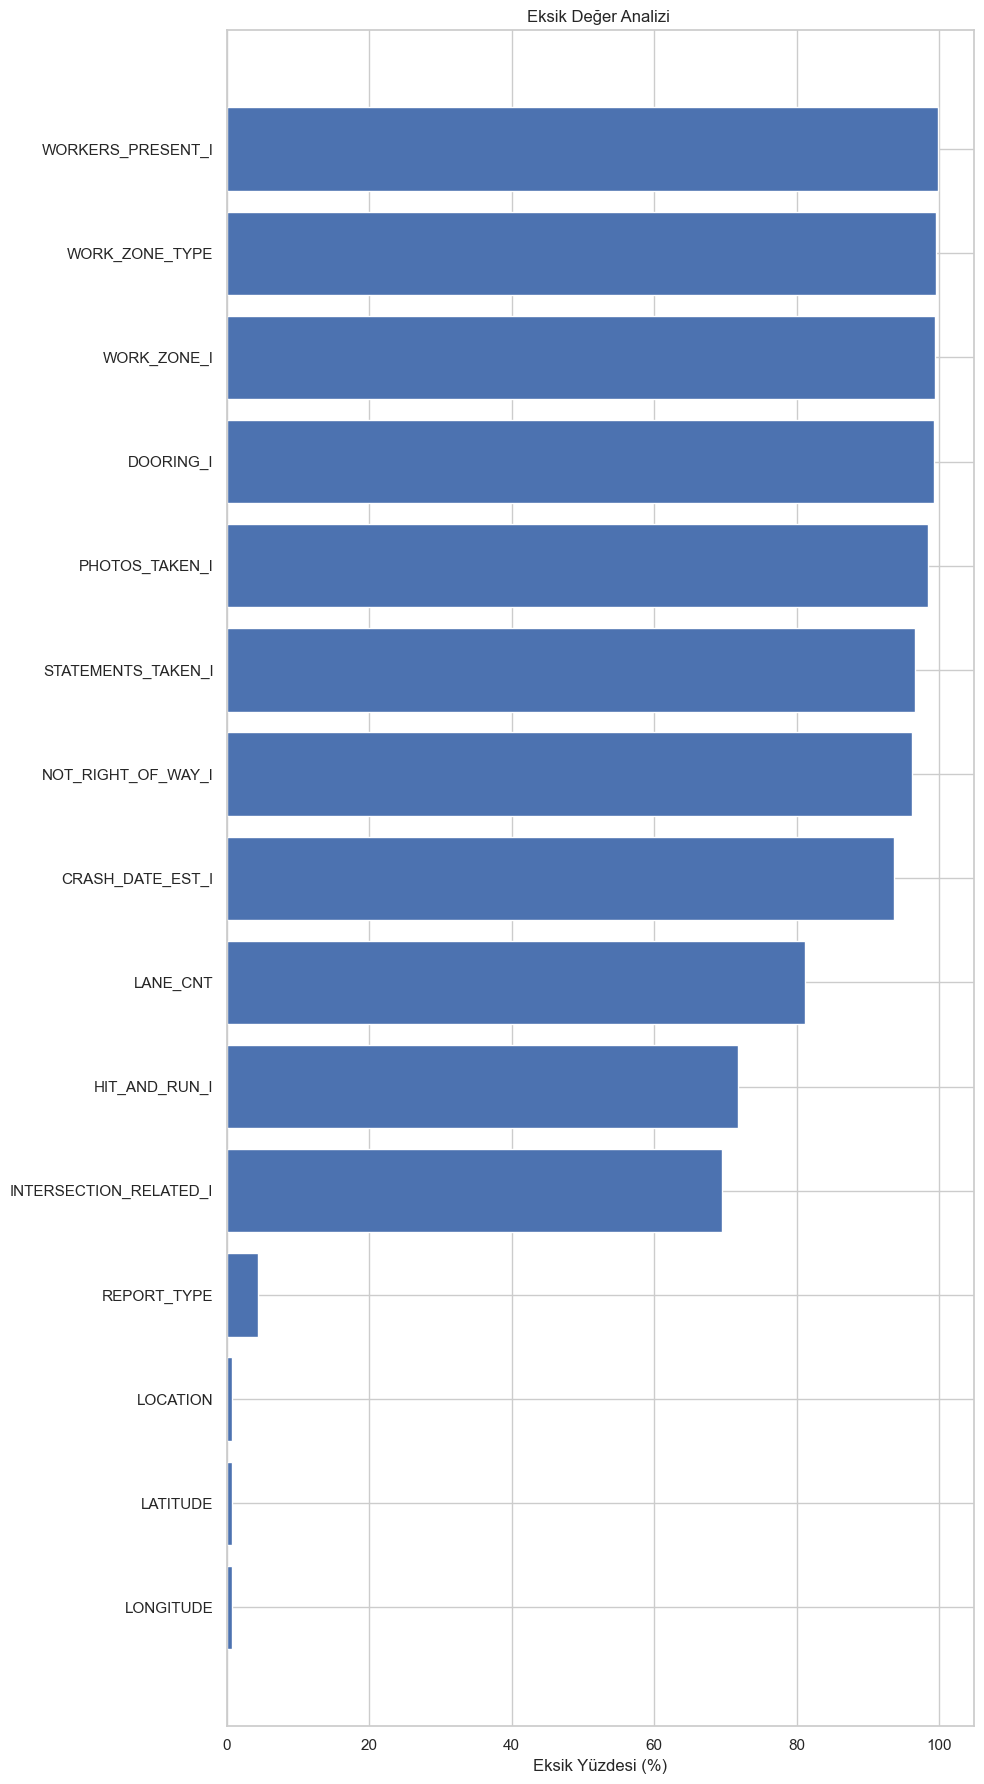

In [9]:
import matplotlib.pyplot as plt

# Eksik değer tablosu 
eksik_sayisi = df.isnull().sum()
eksik_yuzdesi = (eksik_sayisi / len(df)) * 100

eksik_df = pd.DataFrame({
    'eksik_sayisi': eksik_sayisi,
    'eksik_yuzdesi': eksik_yuzdesi
}).sort_values(by='eksik_yuzdesi', ascending=False)

# --- GÖRSELLEŞTİRME ---
plt.figure(figsize=(10, 18))
plt.barh(eksik_df.head(15).index, eksik_df.head(15)['eksik_yuzdesi'])
plt.xlabel("Eksik Yüzdesi (%)")
plt.title("Eksik Değer Analizi ")
plt.gca().invert_yaxis()  # En yüksek değeri üstte göstermek için
plt.tight_layout()
plt.show()

### 6- En Fazla Benzersiz Değere Sahip Sütunlar

Bu adımda veri setindeki sütunlar, içerdiği benzersiz (unique) değer sayısına göre sıralanır. En yüksek 20 sütun listelenerek değişkenlerin çeşitliliği, kategorik alanların karmaşıklığı ve olası yüksek kardinalite sorunları hızlıca tespit edilir.

In [10]:
df.nunique().sort_values(ascending=False).head(20)

CRASH_RECORD_ID                299981
DATE_POLICE_NOTIFIED           276882
CRASH_DATE                     262635
LOCATION                       146837
LATITUDE                       146832
LONGITUDE                      146830
STREET_NO                       10535
STREET_NAME                      1477
BEAT_OF_OCCURRENCE                276
INJURIES_NO_INDICATION             41
PRIM_CONTRIBUTORY_CAUSE            40
SEC_CONTRIBUTORY_CAUSE             40
POSTED_SPEED_LIMIT                 36
LANE_CNT                           27
CRASH_HOUR                         24
TRAFFICWAY_TYPE                    20
INJURIES_NON_INCAPACITATING        20
INJURIES_TOTAL                     20
TRAFFIC_CONTROL_DEVICE             19
FIRST_CRASH_TYPE                   18
dtype: int64

### 7-Kullanılmayan ve Sızıntı (Leakage) Riski Taşıyan Sütunların Kaldırılması
Bu adımda model performansını bozabilecek veya etik olmayan şekilde hedef değişkeni erken söyleyen (leakage) yaralanma sütunları veri setinden çıkarılır. Ayrıca konum, kimlik, tarih, yön bilgisi gibi analizde doğrudan katkı sağlamayan, yüksek kardinaliteye sahip veya gereksiz bulunan sütunlar da temizlenir. Bu işlem, veri setini sadeleştirerek daha sağlam ve genellenebilir bir model oluşturmayı amaçlar.

In [11]:
silinecek_sutunlar = [
    'WORKERS_PRESENT_I','DOORING_I','WORK_ZONE_TYPE','WORK_ZONE_I',
    'PHOTOS_TAKEN_I','STATEMENTS_TAKEN_I','NOT_RIGHT_OF_WAY_I',
    'CRASH_DATE_EST_I','LANE_CNT','INTERSECTION_RELATED_I','HIT_AND_RUN_I',
    'LATITUDE','LONGITUDE','CRASH_RECORD_ID','CRASH_DATE','DATE_POLICE_NOTIFIED',
    'STREET_NO','STREET_DIRECTION','STREET_NAME','LOCATION','REPORT_TYPE', 'BEAT_OF_OCCURRENCE'
]

df.drop(columns=silinecek_sutunlar, inplace=True)
print("Veri boyutu:", df.shape)

Veri boyutu: (299981, 26)


In [12]:
# Yaralanma sütunlarını kaldırma (leakage engelleme)
leak_cols = [
    'INJURIES_TOTAL','INJURIES_FATAL','INJURIES_INCAPACITATING',
    'INJURIES_NON_INCAPACITATING','INJURIES_REPORTED_NOT_EVIDENT',
    'INJURIES_NO_INDICATION','INJURIES_UNKNOWN'
]

df.drop(columns=[c for c in leak_cols if c in df.columns], inplace=True)
print("Veri boyutu:", df.shape)


Veri boyutu: (299981, 19)


### 8- Hedef Değişkeninin Dağılımı

Bu bölümde hedef değişken olan yaralanma şiddeti sınıflarının veri setindeki dağılımı incelenir. Hem yatay bar grafik hem de pasta grafik kullanılarak sınıfların sayısal yoğunluğu ve oranları görselleştirilir. Bu analiz, sınıf dengesizliği (class imbalance) olup olmadığını anlamak ve gerekli dengeleme işlemlerine karar verebilmek için kritik öneme sahiptir.

In [13]:
target = "MOST_SEVERE_INJURY"

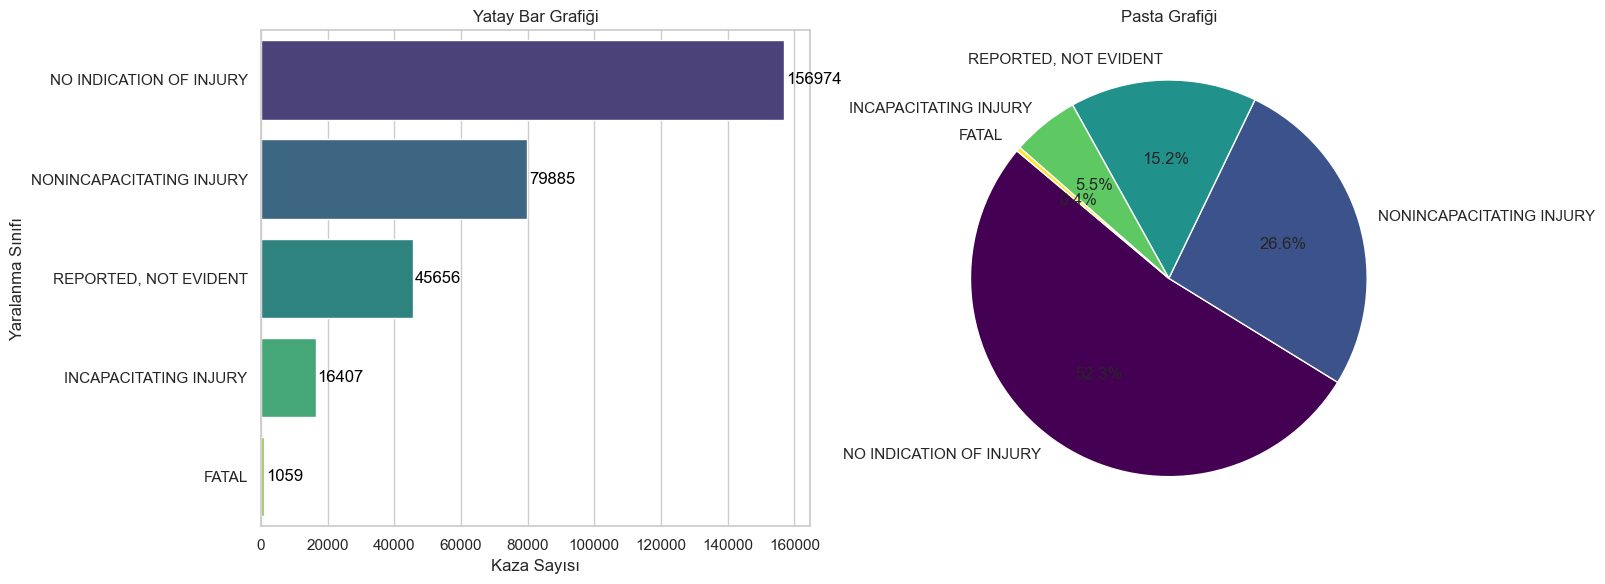

In [14]:
sayi = df[target].value_counts(dropna=False).sort_values(ascending=False)
etiketler = [str(i) if pd.notna(i) else 'NaN' for i in sayi.index]

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
barlar_yatay = sns.barplot(y=etiketler, x=sayi.values, palette="viridis")
for i, v in enumerate(sayi.values):
    barlar_yatay.text(v + 500, i, str(v), color='black', va='center')
plt.title("Yatay Bar Grafiği")
plt.xlabel("Kaza Sayısı")
plt.ylabel("Yaralanma Sınıfı")

plt.subplot(1, 2, 2)
plt.pie(sayi.values, labels=etiketler, autopct='%1.1f%%', startangle=140,
        colors=plt.cm.viridis(np.linspace(0, 1, len(sayi))))
plt.title("Pasta Grafiği")
plt.tight_layout()
plt.show()

In [15]:
# ------------------------------------------
# ### ADIM 4: SINIF DENGESİZLİĞİ KONTROLÜ
# ------------------------------------------
print(f"\n--- Hedef Değişken ({target}) Sınıf Dağılımı ---")
sinif_dagilimi = df[target].value_counts(normalize=True) * 100
print(sinif_dagilimi)

if sinif_dagilimi.max() > 80:
    print("\n[UYARI] Ciddi bir sınıf dengesizliği var. Model eğitiminde 'class_weight' veya SMOTE kullanılması önerilir.")
else:
    print("\nSınıf dağılımı kabul edilebilir düzeyde.")
# ------------------------------------------


--- Hedef Değişken (MOST_SEVERE_INJURY) Sınıf Dağılımı ---
MOST_SEVERE_INJURY
NO INDICATION OF INJURY     52.327981
NONINCAPACITATING INJURY    26.630020
REPORTED, NOT EVIDENT       15.219631
INCAPACITATING INJURY        5.469346
FATAL                        0.353022
Name: proportion, dtype: float64

Sınıf dağılımı kabul edilebilir düzeyde.


### 9- Train-Test Split
Bu adımda veri seti model geliştirme sürecine uygun şekilde üç parçaya ayrılır. İlk olarak verinin %80’i eğitim+doğrulama, %20’si test olarak ayrılır. Ardından eğitim kısmının %5’i validation (doğrulama) seti olarak çekilir. Böylece modelin öğrenme, ayarlama ve değerlendirme aşamalarında veri sızıntısı engellenmiş olur ve daha güvenilir performans ölçümleri sağlanır. Stratify işlemi, sınıf dağılımını her bölmede koruyarak dengesizliğin etkisini azaltır.

In [16]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target])
y = df[target]

# 1. Adım: Veriyi %80 Train (Geçici), %20 Test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Adım: Elimizdeki Train verisinin %5'ini Validation olarak ayır
# Geriye kalan %95 ise Asıl Eğitim (Train) seti olarak kalır.
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.05,  
    random_state=42, 
    stratify=y_train
)

print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

Train: (227984, 18)
Val:   (12000, 18)
Test:  (59997, 18)


### 10- Keşifsel Veri Analizi (EDA)
Keşifsel Veri Analizi, veri setini daha yakından tanımamızı sağlayan önemli bir aşamadır. Bu bölümde amaç, verilerin içerdiği ilişki ve örüntüleri görselleştirmeler ve istatistiksel özetler üzerinden keşfetmektir. Hangi değişkenlerin hangi değerlerde yoğunlaştığını, uç değerlerin olup olmadığını, kategorik değişkenlerin dağılımını, sayısal değişkenlerin genel eğilimlerini ve hedef değişken ile diğer sütunlar arasındaki ilişkileri anlamaya çalışırız. Böylece veri setinin güçlü yönlerini, sorunlu alanlarını ve modelin öğrenmesi açısından potansiyel etkisi olan değişkenleri daha net görürüz.

<Figure size 2000x600 with 0 Axes>

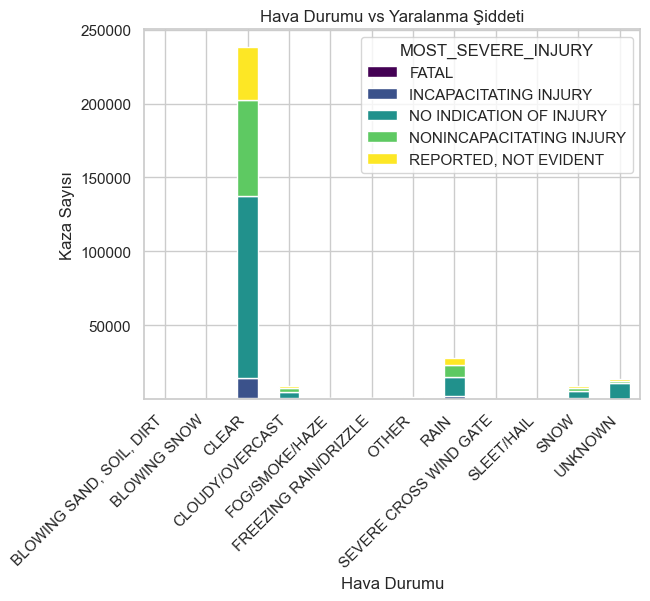

In [17]:
# WEATHER_CONDITION vs MOST_SEVERE_INJURY
plt.figure(figsize=(20,6))
cross = df.groupby(['WEATHER_CONDITION', 'MOST_SEVERE_INJURY']).size().unstack(fill_value=0)
cross.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Hava Durumu vs Yaralanma Şiddeti")
plt.xlabel("Hava Durumu")
plt.ylabel("Kaza Sayısı")
plt.xticks(rotation=45, ha='right')
plt.show()

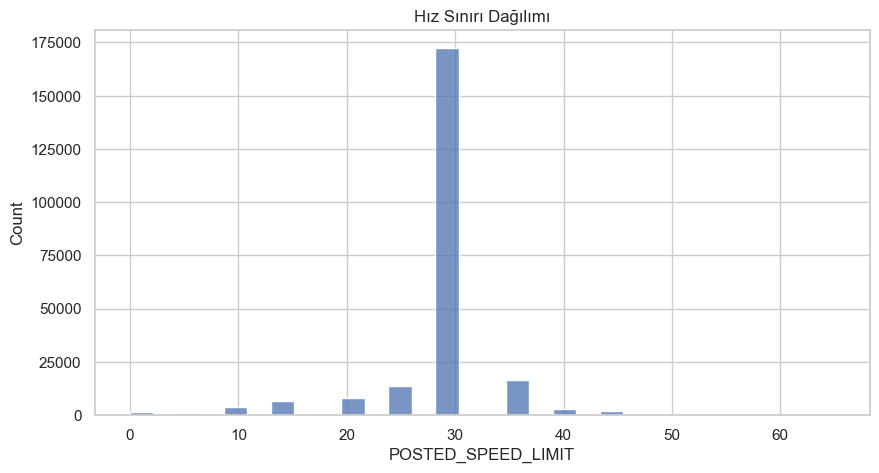

In [18]:
# Hız sınırı grafiği
plt.figure(figsize=(10,5))
sns.histplot(X_train['POSTED_SPEED_LIMIT'], bins=30)
plt.title("Hız Sınırı Dağılımı")
plt.show()

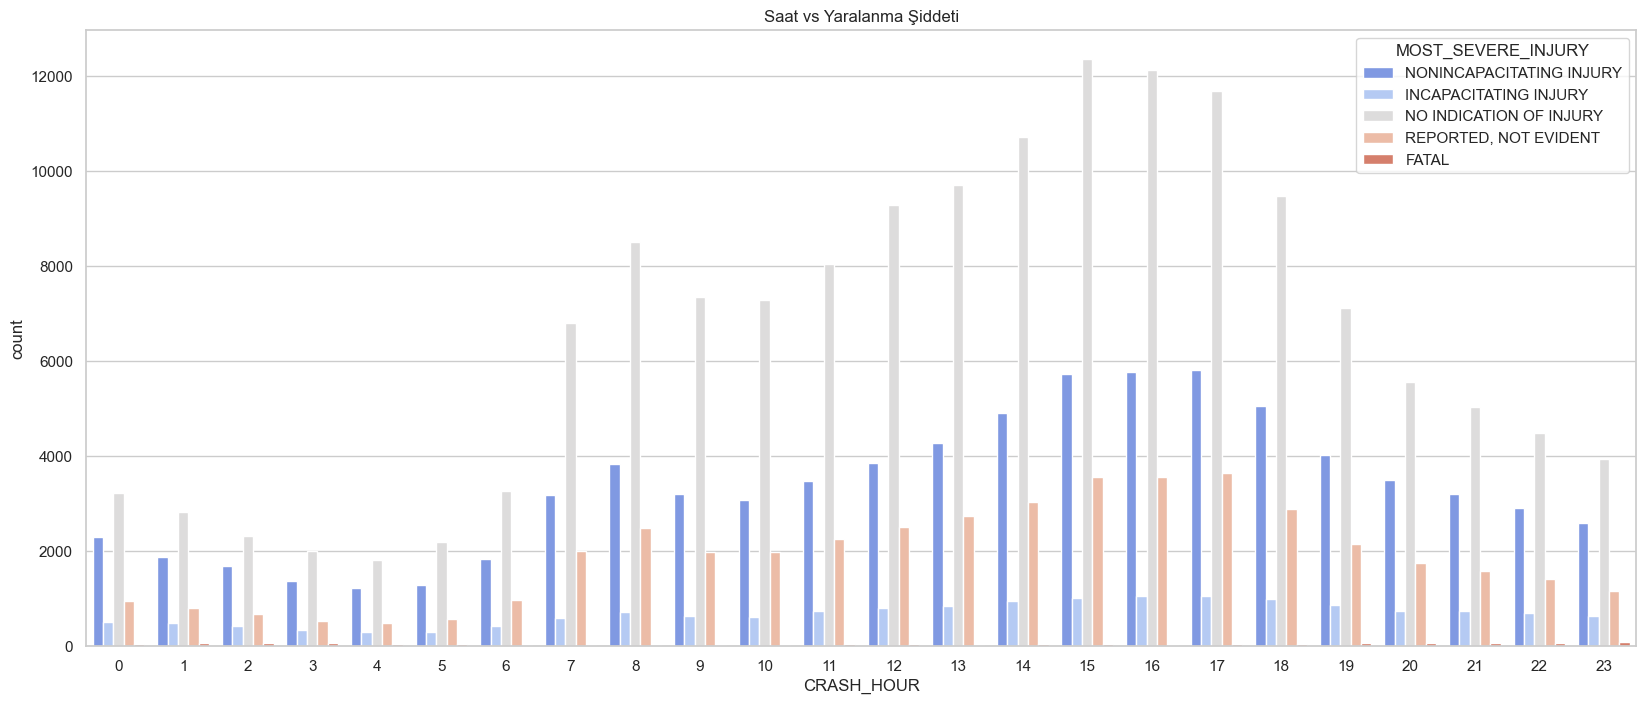

In [19]:
plt.figure(figsize=(20, 8))
sns.countplot(x='CRASH_HOUR', hue='MOST_SEVERE_INJURY', data=df, palette='coolwarm')
plt.title("Saat vs Yaralanma Şiddeti")
plt.show()


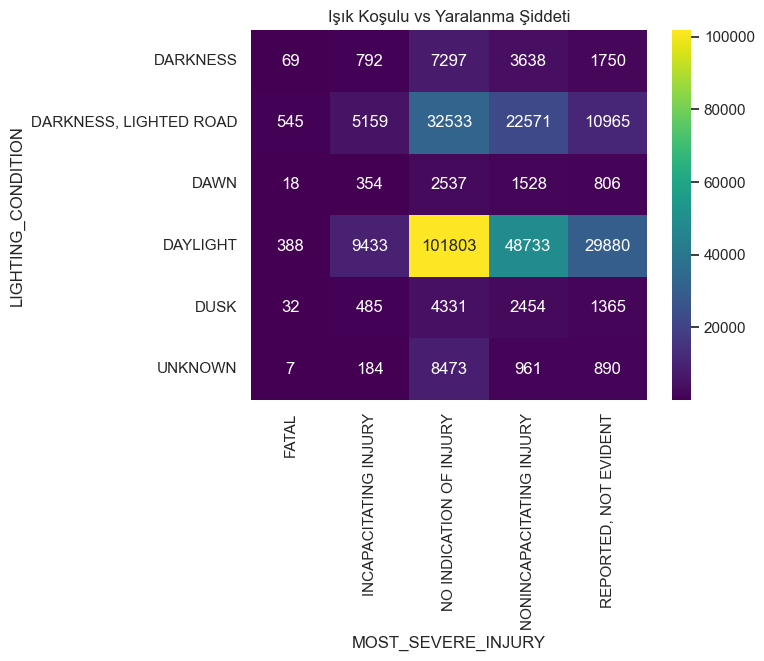

In [20]:
cross = df.groupby(['LIGHTING_CONDITION', 'MOST_SEVERE_INJURY']).size().unstack(fill_value=0)
sns.heatmap(cross, annot=True, fmt='d', cmap='viridis')
plt.title("Işık Koşulu vs Yaralanma Şiddeti")
plt.show()

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
# sayısal ve kategorik sütunları belirlenmesi
sayisal_sutunlar = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
kategorik_sutunlar = df.select_dtypes(include=['object']).columns.tolist()
# Hedef değişken sayısal listeden çıkarılıyor
if 'MOST_SEVERE_INJURY' in sayisal_sutunlar:
    sayisal_sutunlar.remove('MOST_SEVERE_INJURY')
if 'MOST_SEVERE_INJURY' in kategorik_sutunlar:
    kategorik_sutunlar.remove('MOST_SEVERE_INJURY')

print("Sayısal sütun sayısı:", len(sayisal_sutunlar))
print("Kategorik sütun sayısı:", len(kategorik_sutunlar))


Sayısal sütun sayısı: 5
Kategorik sütun sayısı: 13


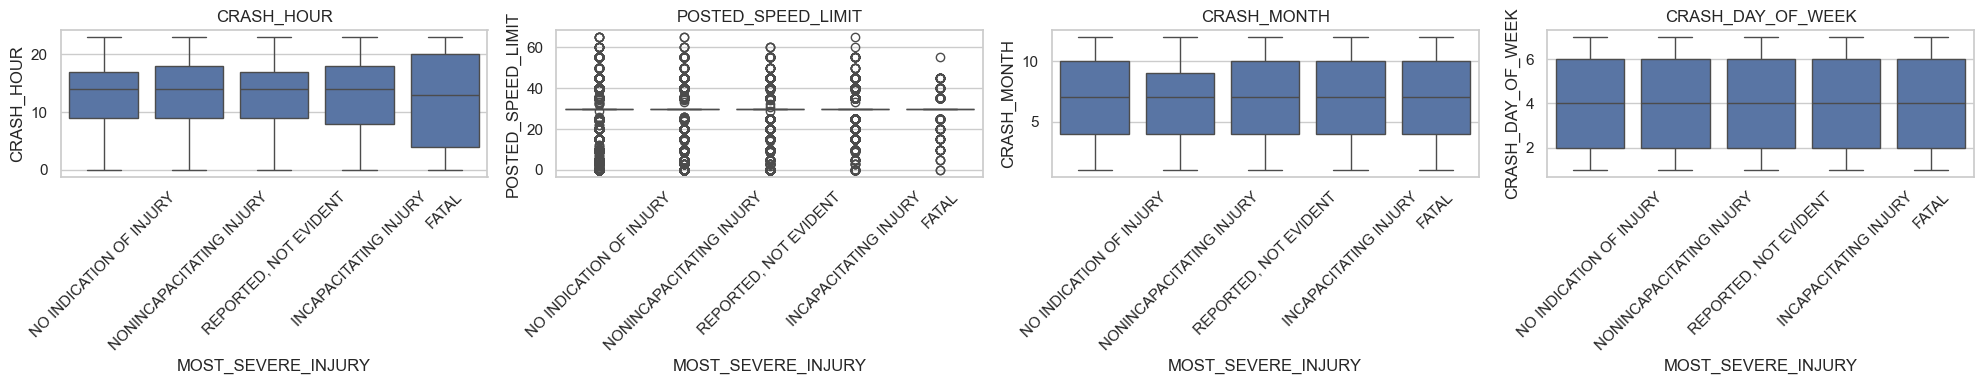

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_box_df = X_train.copy()
train_box_df["MOST_SEVERE_INJURY"] = y_train.values 

num_cols = train_box_df.select_dtypes(include=[np.number]).columns

var_series = train_box_df[num_cols].var().sort_values(ascending=False)
top_num_for_box = var_series.head(4).index

fig, axes = plt.subplots(1, len(top_num_for_box), figsize=(5 * len(top_num_for_box), 4))
if len(top_num_for_box) == 1:
    axes = [axes]

for ax, col in zip(axes, top_num_for_box):
    sns.boxplot(data=train_box_df, x="MOST_SEVERE_INJURY", y=col, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

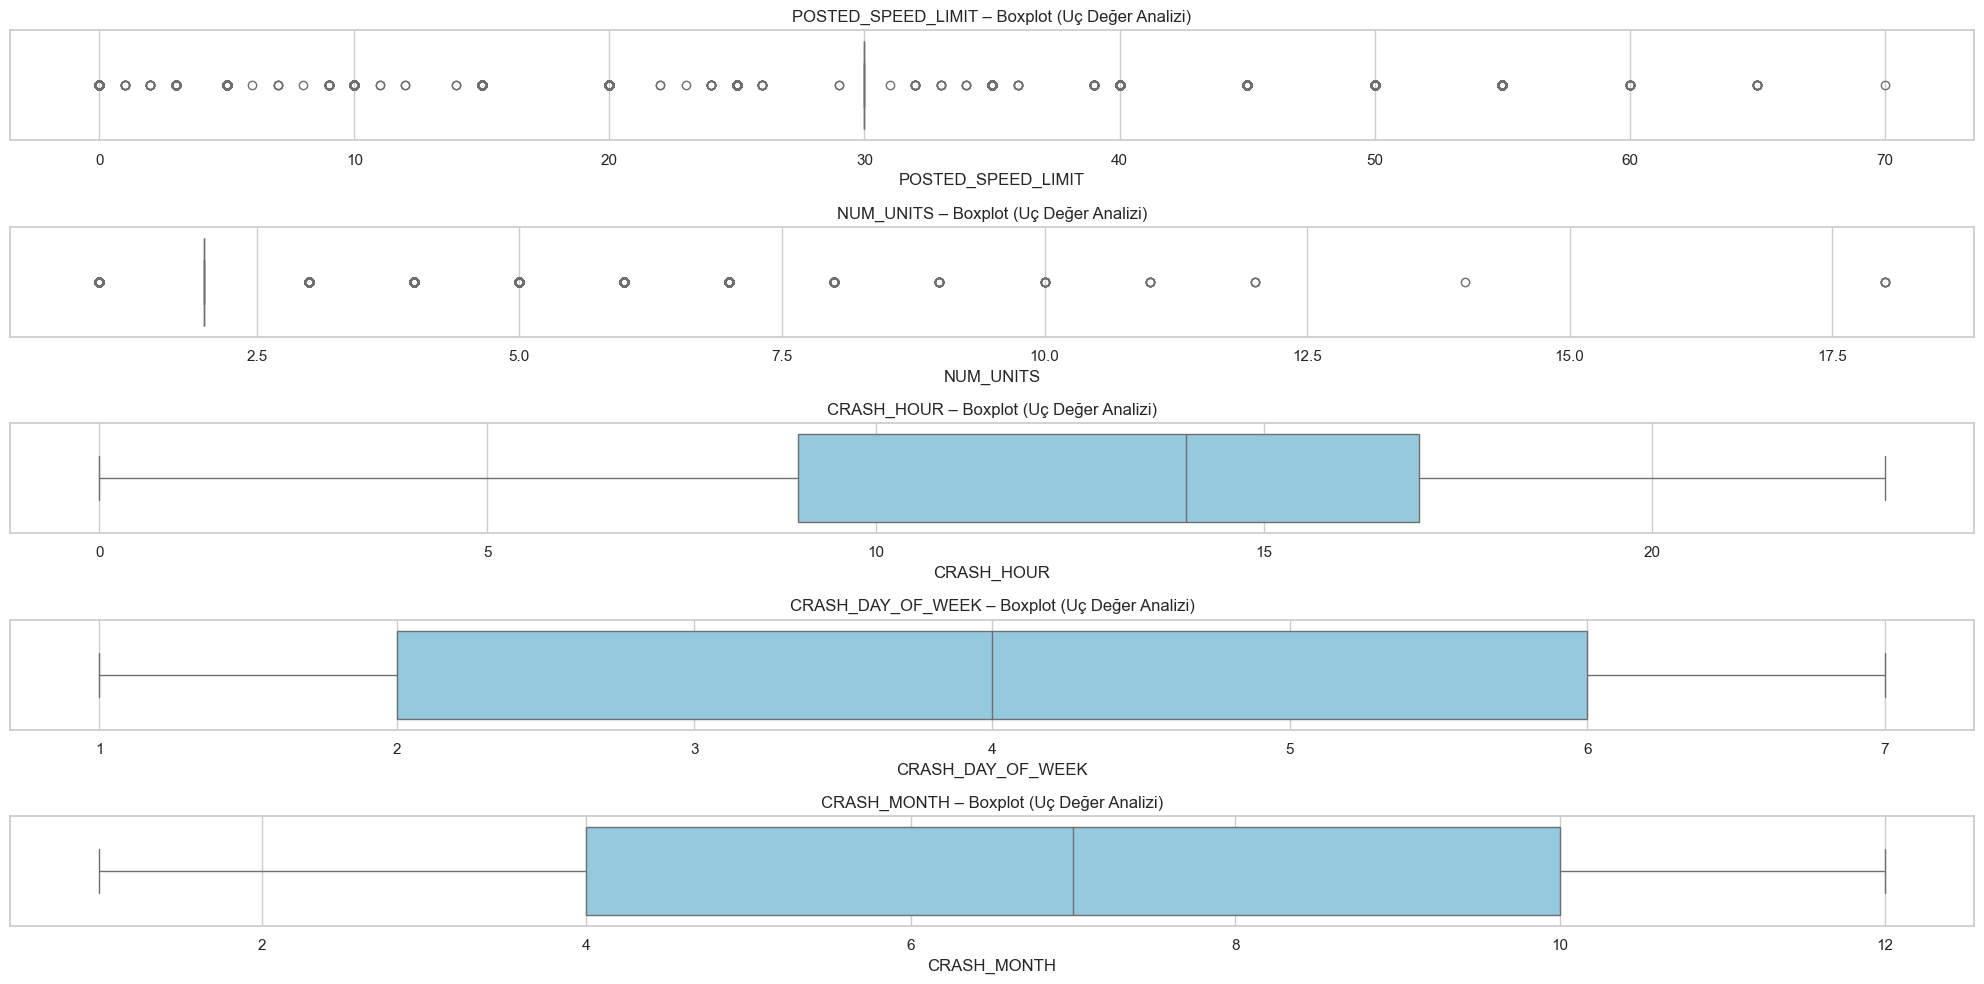

In [23]:
#SAYISAL SÜTUNLAR – UÇ DEĞER ANALİZİ
plt.figure(figsize=(20, len(sayisal_sutunlar) * 2))

for i, col in enumerate(sayisal_sutunlar, 1):
    plt.subplot(len(sayisal_sutunlar), 1, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f"{col} – Boxplot (Uç Değer Analizi)", fontsize=12)

plt.tight_layout()
plt.show()

In [24]:
# 5. Aykırı Değerleri Belirleme 
outlier_report = {}
num_cols = X_train.select_dtypes(include=[np.number]).columns
for c in num_cols:
    q1 = X_train[c].quantile(0.25)
    q3 = X_train[c].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr
    lower = q1 - 1.5 * iqr
    outlier_rate = ((X_train[c] < lower) | (X_train[c] > upper)).mean() * 100
    outlier_report[c] = round(outlier_rate, 2)

outlier_df = pd.DataFrame(list(outlier_report.items()), columns=["Sütun", "Aykırı Değer Oranı (%)"])
outlier_df = outlier_df.sort_values(by="Aykırı Değer Oranı (%)", ascending=False)

print("\nAykırı değer oranı en yüksek sütunlar:")
print(outlier_df.head(10))


Aykırı değer oranı en yüksek sütunlar:
                Sütun  Aykırı Değer Oranı (%)
0  POSTED_SPEED_LIMIT                   24.46
1           NUM_UNITS                   15.29
2          CRASH_HOUR                    0.00
3   CRASH_DAY_OF_WEEK                    0.00
4         CRASH_MONTH                    0.00


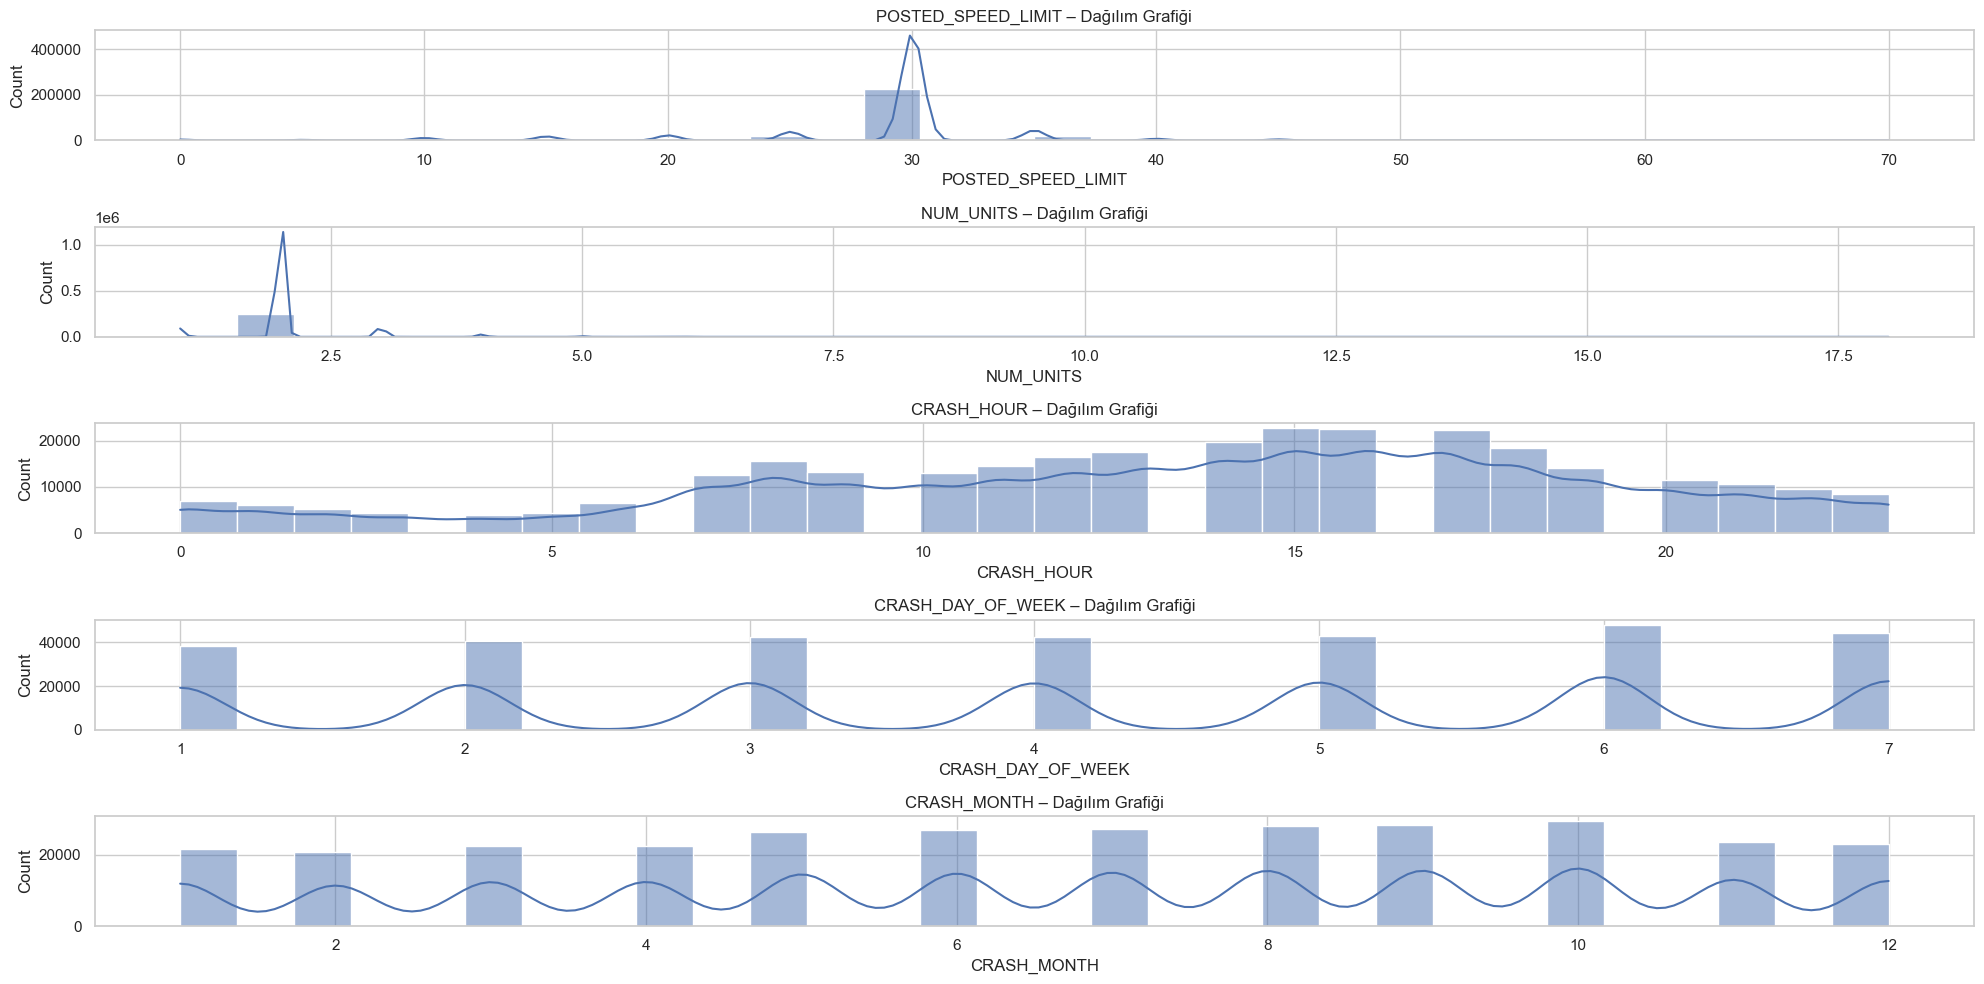

In [25]:
#SAYISAL DEĞİŞKENLERİN DAĞILIMI 
plt.figure(figsize=(20, len(sayisal_sutunlar) * 2))

for i, col in enumerate(sayisal_sutunlar, 1):
    plt.subplot(len(sayisal_sutunlar), 1, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"{col} – Dağılım Grafiği", fontsize=12)

plt.tight_layout()
plt.show()

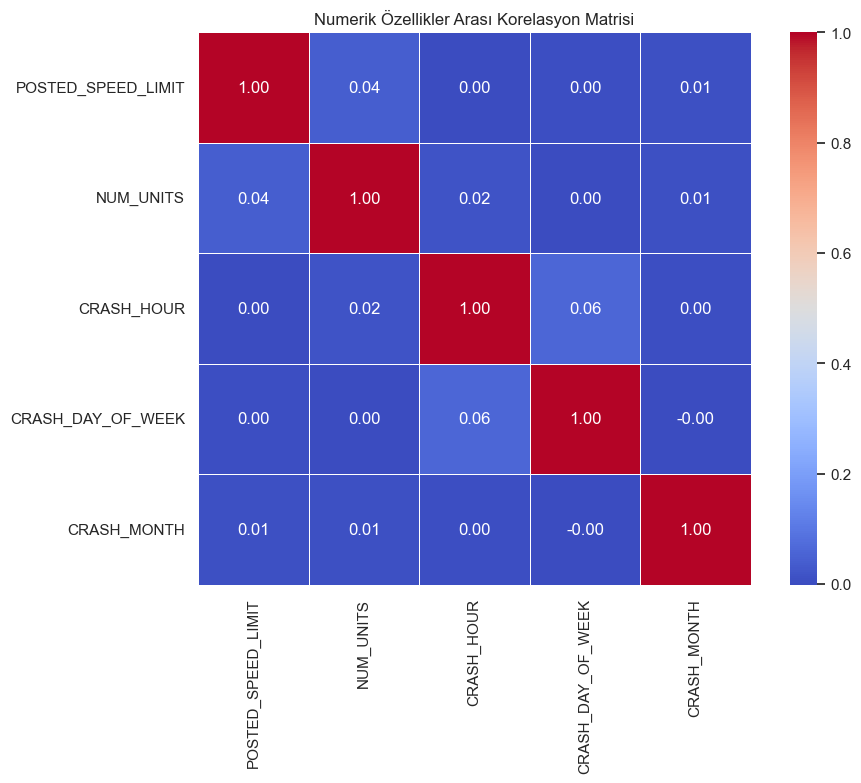

In [26]:
# =========================
# Amaç:
# - Numerik sütunların birbirleriyle olan ilişkisini (korelasyon) görmek
# - Çok güçlü ilişkili (yüksek korelasyonlu) değişkenleri tespit etmek
# - Gereksiz (birbirini tekrar eden) özellik olup olmadığını anlamak

# 1) Sadece numerik sütunları al
X_train_num_corr = X_train[sayisal_sutunlar].copy()

# 2) Korelasyon matrisi hesapla (varsayılan = Pearson)
corr_matrix = X_train_num_corr.corr()

# 3) Korelasyon matrisini görselleştir (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,           # Hücrelere korelasyon değerini yaz
    fmt=".2f",            # 2 basamak göster
    cmap="coolwarm",      
    square=True,
    linewidths=0.5
)
plt.title("Numerik Özellikler Arası Korelasyon Matrisi")
plt.tight_layout()
plt.show()

In [27]:
# Veri yapısı bilgisi
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299981 entries, 0 to 299999
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   POSTED_SPEED_LIMIT       299981 non-null  int64 
 1   TRAFFIC_CONTROL_DEVICE   299981 non-null  object
 2   DEVICE_CONDITION         299981 non-null  object
 3   WEATHER_CONDITION        299981 non-null  object
 4   LIGHTING_CONDITION       299981 non-null  object
 5   FIRST_CRASH_TYPE         299981 non-null  object
 6   TRAFFICWAY_TYPE          299981 non-null  object
 7   ALIGNMENT                299981 non-null  object
 8   ROADWAY_SURFACE_COND     299981 non-null  object
 9   ROAD_DEFECT              299981 non-null  object
 10  CRASH_TYPE               299981 non-null  object
 11  DAMAGE                   299981 non-null  object
 12  PRIM_CONTRIBUTORY_CAUSE  299981 non-null  object
 13  SEC_CONTRIBUTORY_CAUSE   299981 non-null  object
 14  NUM_UNITS                

### 11- 1.Base Model: Passive-Aggressive Classifier

Bu aşamada temel model olarak Passive-Aggressive Classifier kullanılmıştır. Bu model, büyük ve yüksek boyutlu veri setlerinde hızlı çalışması, çevrimiçi öğrenmeye uygun olması ve özellikle metin/kategorik ağırlıklı verilerde iyi performans göstermesi nedeniyle tercih edilmiştir. Ayrıca sınıf dengesizliğine duyarlı çalışabilmesi de bu projede önemli bir avantaj sağlamaktadır.
Pipeline içinde sayısal değişkenler ölçeklenmiş, kategorik değişkenler One-Hot Encode edilmiştir. Ardından model eğitilmiş ve validation seti üzerinde doğruluk, sınıflandırma raporu ve karmaşıklık matrisi ile performansı değerlendirilmiştir.

In [28]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ön İşleme (Preprocessing) Adımlarının Tanımlanması
# ---------------------------------------------------------
# Sayısal Sütunlar: Eksikleri medyan ile doldur + Standartlaştır
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Kategorik Sütunlar: Eksikleri 'MISSING' ile doldur + One-Hot Encode yap
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# İki yolu birleştir (ColumnTransformer)

preprocessor = ColumnTransformer([
    ('num', num_pipeline, sayisal_sutunlar),
    ('cat', cat_pipeline, kategorik_sutunlar)
])

In [29]:
# 2. Base Model Pipeline'ının Kurulması (Passive-Aggressive Classifier)
# ---------------------------------------------------------
# C parametresi: Düzenlileştirme (regularization) parametresidir. Varsayılan 1.0'dır.
# max_iter: Maksimum iterasyon sayısı.
# random_state: Sonuçların tekrarlanabilir olması için.
base_model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', PassiveAggressiveClassifier(
        C=1.0, 
        max_iter=1000, 
        random_state=42,
        class_weight='balanced', # Sınıf dengesizliği için önemli
        n_jobs=-1 # Mümkünse paralel işlem
    ))
])

In [30]:
# 3. Modeli Eğit (Train Seti ile)
# ---------------------------------------------------------
print("Base Model (Passive-Aggressive) eğitiliyor...")
base_model_pipeline.fit(X_train, y_train)
print("Eğitim tamamlandı.")

Base Model (Passive-Aggressive) eğitiliyor...
Eğitim tamamlandı.


In [31]:
# 4. Doğrulama (Validation) Seti ile Performansı Ölç
# ---------------------------------------------------------
print("\n--- Base Model (Passive-Aggressive) Sonuçları (Validation Set) ---")
y_base_pred = base_model_pipeline.predict(X_val)

# Metrikleri Yazdır
base_acc = accuracy_score(y_val, y_base_pred)
print(f"Base Model Doğruluk (Accuracy): {base_acc:.4f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_val, y_base_pred))


--- Base Model (Passive-Aggressive) Sonuçları (Validation Set) ---
Base Model Doğruluk (Accuracy): 0.5472

Sınıflandırma Raporu:
                          precision    recall  f1-score   support

                   FATAL       0.01      0.79      0.02        42
   INCAPACITATING INJURY       0.09      0.12      0.10       656
 NO INDICATION OF INJURY       0.96      0.87      0.91      6279
NONINCAPACITATING INJURY       0.52      0.21      0.30      3196
   REPORTED, NOT EVIDENT       0.42      0.19      0.26      1827

                accuracy                           0.55     12000
               macro avg       0.40      0.43      0.32     12000
            weighted avg       0.71      0.55      0.60     12000



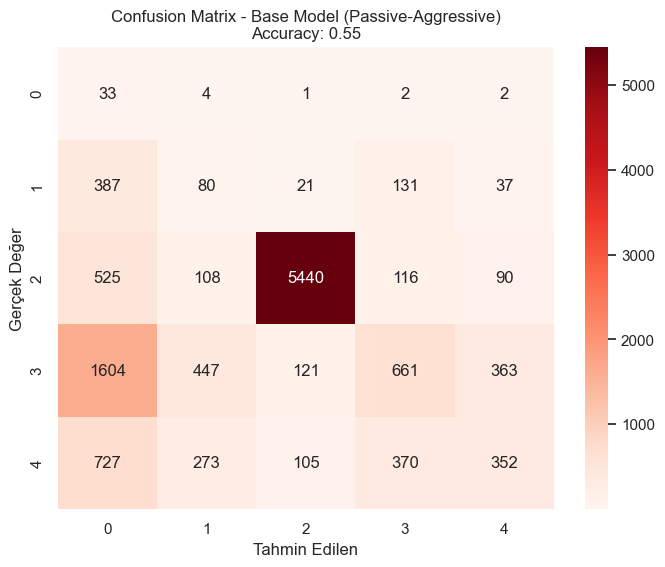

In [32]:
# Karmaşıklık Matrisi (Confusion Matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_base_pred), annot=True, fmt='d', cmap='Reds')
plt.title(f"Confusion Matrix - Base Model (Passive-Aggressive)\nAccuracy: {base_acc:.2f}")
plt.ylabel("Gerçek Değer")
plt.xlabel("Tahmin Edilen")
plt.show()

### 12- 2. Base Model: Balanced Logistic Regression

Bu aşamada ikinci temel model olarak Logistic Regression tercih edilmiştir. Çünkü bu model, çok sınıflı problemler için güçlü bir doğrusal referans sunar, yorumlanabilirliği yüksektir ve hangi değişkenlerin sınıfları etkilediğini anlamaya yardımcı olur. Ayrıca class_weight='balanced' kullanılarak veri setindeki sınıf dengesizliği (özellikle ağır yaralanma/ölüm gibi az görülen sınıflar) modele daha adil şekilde yansıtılmıştır.
Ön işlem adımları önceki yapıyla aynı tutulmuş (sayısal veriler ölçeklenmiş, kategorik veriler One-Hot Encode edilmiştir) ve tüm süreç Pipeline içine alınmıştır. Model eğitildikten sonra validation setinde doğruluk, sınıflandırma raporu ve confusion matrix ile performans değerlendirmesi yapılmıştır.

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ön İşleme (Mevcut yapıyı koruyoruz)
# ---------------------------------------------------------


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # One-Hot Encoding
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, sayisal_sutunlar),
    ('cat', cat_pipeline, kategorik_sutunlar)
])

In [34]:
# 2. Yeni Base Model Pipeline'ı (Balanced Logistic Regression)
# ---------------------------------------------------------
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced',  # Dengesiz sınıfları (Ölümcül kazalar) öne çıkarır!
        random_state=42,
        max_iter=1000,            # Yakınsama için iterasyon sayısını artırdık
        n_jobs=-1,                # Tüm işlemcileri kullan
        solver='saga'             # Büyük ve sparse veri setleri için hızlıdır
    ))
])

In [35]:
# 3. Modeli Eğit
# ---------------------------------------------------------
print("Yeni Base Model (Balanced Logistic Regression) eğitiliyor...")
logreg_pipeline.fit(X_train, y_train)
print("Eğitim tamamlandı.")

Yeni Base Model (Balanced Logistic Regression) eğitiliyor...
Eğitim tamamlandı.


In [36]:
# 4. Doğrulama (Validation) Sonuçları
# ---------------------------------------------------------
print("\n--- Balanced Logistic Regression Sonuçları (Validation Set) ---")
y_log_pred = logreg_pipeline.predict(X_val)

# Metrikler
log_acc = accuracy_score(y_val, y_log_pred)
print(f"Model Doğruluk (Accuracy): {log_acc:.4f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_val, y_log_pred))


--- Balanced Logistic Regression Sonuçları (Validation Set) ---
Model Doğruluk (Accuracy): 0.6123

Sınıflandırma Raporu:
                          precision    recall  f1-score   support

                   FATAL       0.02      0.71      0.04        42
   INCAPACITATING INJURY       0.15      0.25      0.19       656
 NO INDICATION OF INJURY       1.00      0.86      0.93      6279
NONINCAPACITATING INJURY       0.52      0.20      0.29      3196
   REPORTED, NOT EVIDENT       0.37      0.60      0.46      1827

                accuracy                           0.61     12000
               macro avg       0.41      0.53      0.38     12000
            weighted avg       0.72      0.61      0.64     12000



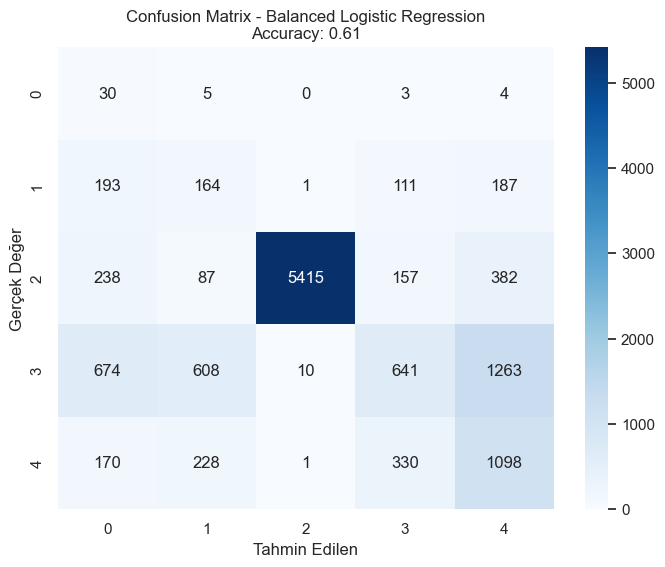

In [37]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_log_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - Balanced Logistic Regression\nAccuracy: {log_acc:.2f}")
plt.ylabel("Gerçek Değer")
plt.xlabel("Tahmin Edilen")
plt.show()

### 13- Feature Selection: SelectKBest ile En İyi Değişkenleri Belirleme

Bu adımda modelin gereksiz veya düşük katkılı özelliklerden etkilenmesini azaltmak için özellik seçimi (feature selection) uygulanmıştır. Önce sayısal ve kategorik sütunlar ayrılmış, eksikler doldurulup sayısal veriler ölçeklenmiş ve kategorik veriler One-Hot Encoding ile genişletilmiştir. Daha sonra oluşan yüksek boyutlu özellik uzayından, hedef değişkenle en güçlü ilişkiye sahip olanlar ANOVA F-testi (f_classif) kullanılarak sıralanmış ve en iyi 300 özellik seçilmiştir. Böylece veri boyutu düşürülerek daha hızlı, daha kararlı ve genellenebilir bir model elde etmek amaçlanmıştır.

In [38]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import numpy as np

# 1. Sütunları Grupla 
# ---------------------------------------------------------

sayisal_sutunlar = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
kategorik_sutunlar = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Sayısal Sütunlar ({len(sayisal_sutunlar)} adet): {sayisal_sutunlar}")
print(f"Kategorik Sütunlar ({len(kategorik_sutunlar)} adet): {kategorik_sutunlar}")

Sayısal Sütunlar (5 adet): ['POSTED_SPEED_LIMIT', 'NUM_UNITS', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH']
Kategorik Sütunlar (13 adet): ['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'CRASH_TYPE', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE']


In [39]:
# 2. Ön İşleme Pipeline'ı (Feature Selection için veri hazırla)
# ---------------------------------------------------------
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    # sparse_output=False: İşlem kolaylığı için yoğun matris (dense) üretiyoruz
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, sayisal_sutunlar),
    ('cat', cat_pipeline, kategorik_sutunlar)
], verbose_feature_names_out=False) # Sütun isimlerini sade tutar

In [40]:
# 3. Veriyi Dönüştür ve Özellik İsimlerini Al
# ---------------------------------------------------------
print("\nVeri ön işleniyor ve One-Hot Encoding yapılıyor...")
# Sadece transform yapıyoruz, model eğitmiyoruz
X_train_transformed = preprocessor.fit_transform(X_train)

# Oluşan tüm özellik isimlerini (One-Hot dahil) çekelim
try:
    # Scikit-learn güncel sürümlerinde çalışır
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # Eski sürümler için manuel isimlendirme
    feature_names = np.array([f"Feature_{i}" for i in range(X_train_transformed.shape[1])])

print(f"Genişletilmiş Toplam Özellik Sayısı: {len(feature_names)}")


Veri ön işleniyor ve One-Hot Encoding yapılıyor...
Genişletilmiş Toplam Özellik Sayısı: 193


In [41]:
# 4. Feature Selection Uygula (SelectKBest)
# ---------------------------------------------------------
# En iyi 100 özelliği seç 
k_best = 100 
# k değeri toplam özellik sayısından büyük olamaz, kontrol edelim:
k_best = min(k_best, len(feature_names))

print(f"\nEn iyi {k_best} özellik seçiliyor...")
selector = SelectKBest(score_func=f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train_transformed, y_train)


En iyi 100 özellik seçiliyor...


In [42]:
# 5. Seçilen Özellikleri Listele
# ---------------------------------------------------------
# get_support(): Hangi sütunların seçildiğini True/False olarak döndürür
selected_mask = selector.get_support()
selected_features = feature_names[selected_mask]

print(f"Seçilen Özellik Sayısı: {len(selected_features)}")
print("\n--- Seçilen İlk 20 Özellik ---")
print(selected_features[:20])

Seçilen Özellik Sayısı: 100

--- Seçilen İlk 20 Özellik ---
['POSTED_SPEED_LIMIT' 'NUM_UNITS' 'CRASH_MONTH'
 'TRAFFIC_CONTROL_DEVICE_NO CONTROLS'
 'TRAFFIC_CONTROL_DEVICE_PEDESTRIAN CROSSING SIGN'
 'TRAFFIC_CONTROL_DEVICE_STOP SIGN/FLASHER'
 'TRAFFIC_CONTROL_DEVICE_TRAFFIC SIGNAL' 'TRAFFIC_CONTROL_DEVICE_UNKNOWN'
 'DEVICE_CONDITION_FUNCTIONING IMPROPERLY'
 'DEVICE_CONDITION_FUNCTIONING PROPERLY' 'DEVICE_CONDITION_NO CONTROLS'
 'DEVICE_CONDITION_UNKNOWN' 'WEATHER_CONDITION_CLEAR'
 'WEATHER_CONDITION_RAIN' 'WEATHER_CONDITION_SNOW'
 'WEATHER_CONDITION_UNKNOWN' 'LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD'
 'LIGHTING_CONDITION_DAYLIGHT' 'LIGHTING_CONDITION_UNKNOWN'
 'FIRST_CRASH_TYPE_ANGLE']


In [43]:
# Seçilenlerin skorlarını (önem derecelerini) görmek istersek:
scores = selector.scores_[selected_mask]
feature_score_df = pd.DataFrame({'Özellik': selected_features, 'Skor': scores})
print("\n--- En Yüksek Skorlu 10 Özellik ---")
print(feature_score_df.sort_values(by='Skor', ascending=False).head(10))


--- En Yüksek Skorlu 10 Özellik ---
                                        Özellik           Skor
57            CRASH_TYPE_NO INJURY / DRIVE AWAY  155990.123615
56  CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH  155990.123615
27                  FIRST_CRASH_TYPE_PEDESTRIAN    5734.393350
25        FIRST_CRASH_TYPE_PARKED MOTOR VEHICLE    4499.884142
26                FIRST_CRASH_TYPE_PEDALCYCLIST    2596.570648
59                         DAMAGE_$501 - $1,500    2165.069683
32    FIRST_CRASH_TYPE_SIDESWIPE SAME DIRECTION    1798.200931
9         DEVICE_CONDITION_FUNCTIONING PROPERLY    1779.743060
3            TRAFFIC_CONTROL_DEVICE_NO CONTROLS    1665.910725
10                 DEVICE_CONDITION_NO CONTROLS    1532.579732


### 14- Özellik Seçimi Sonrası Modellerin Karşılaştırılması

Bu bölümde, yüksek boyutlu One-Hot sonrası veri setini sadeleştirmek için SelectKBest (ANOVA F-test) ile hedef değişkenle en ilişkili 300 özellik seçildi. Amaç; gürültüyü azaltıp modeli hızlandırmak ve genellenebilirliği artırmaktı.
Aynı ön-işleme ve özellik seçimi adımları korunarak iki farklı base model kuruldu: Passive-Aggressive Classifier (hızlı ve büyük veride güçlü bir lineer referans) ve Balanced Logistic Regression (yorumlanabilir, sağlam lineer benchmark). Her iki model validation setinde eğitilip accuracy ve classification report ile değerlendirildi; ayrıca seçilen özelliklerin ilk örnekleri gösterilerek hangi değişkenlerin öne çıktığı incelendi.

In [44]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preprocessing Pipeline (Ortak)
# ---------------------------------------------------------
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, sayisal_sutunlar),
    ('cat', cat_pipeline, kategorik_sutunlar)
], verbose_feature_names_out=False)

# Özellik İsimlerini Yakalamak İçin Bir Fonksiyon
def get_selected_feature_names(pipeline, X_train):
    # 1. Preprocessor'dan geçen özellik isimlerini al
    # (Not: Pipeline fit edildikten sonra çalışır)
    try:
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    except AttributeError:
        # Eski sklearn sürümleri için fallback
        feature_names = np.array(["Feature_" + str(i) for i in range(3000)]) # Tahmini

    # 2. SelectKBest tarafından seçilenlerin maskesini al (True/False)
    mask = pipeline.named_steps['feature_selection'].get_support()
    
    # 3. İsimleri filtrele
    selected_features = feature_names[mask]
    return selected_features

In [45]:
# --- MODEL 1: Passive-Aggressive Classifier ---
print("\n" + "="*50)
print("MODEL 1: Feature Selection + Passive-Aggressive Classifier")
print("="*50)

# Pipeline Kurulumu
pa_fs_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=100)), # En iyi 100
    ('classifier', PassiveAggressiveClassifier(
        class_weight='balanced', 
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    ))
])

# Eğit
pa_fs_pipeline.fit(X_train, y_train)

# Tahmin ve Skor
y_pred_pa = pa_fs_pipeline.predict(X_val)
acc_pa = accuracy_score(y_val, y_pred_pa)

print(f"Accuracy: {acc_pa:.4f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_val, y_pred_pa))

# Seçilen Özellikleri Göster
selected_feats_pa = get_selected_feature_names(pa_fs_pipeline, X_train)
print(f"\n>>> Passive-Aggressive için Seçilen {len(selected_feats_pa)} Özellikten İlk 10'u:")
print(selected_feats_pa[:10])


MODEL 1: Feature Selection + Passive-Aggressive Classifier
Accuracy: 0.5459

Sınıflandırma Raporu:
                          precision    recall  f1-score   support

                   FATAL       0.01      0.76      0.02        42
   INCAPACITATING INJURY       0.07      0.07      0.07       656
 NO INDICATION OF INJURY       0.92      0.87      0.89      6279
NONINCAPACITATING INJURY       0.58      0.06      0.11      3196
   REPORTED, NOT EVIDENT       0.37      0.45      0.40      1827

                accuracy                           0.55     12000
               macro avg       0.39      0.44      0.30     12000
            weighted avg       0.70      0.55      0.56     12000


>>> Passive-Aggressive için Seçilen 100 Özellikten İlk 10'u:
['POSTED_SPEED_LIMIT' 'NUM_UNITS' 'CRASH_MONTH'
 'TRAFFIC_CONTROL_DEVICE_NO CONTROLS'
 'TRAFFIC_CONTROL_DEVICE_PEDESTRIAN CROSSING SIGN'
 'TRAFFIC_CONTROL_DEVICE_STOP SIGN/FLASHER'
 'TRAFFIC_CONTROL_DEVICE_TRAFFIC SIGNAL' 'TRAFFIC_CONTROL_DE

In [46]:
# --- MODEL 2: Balanced Logistic Regression ---
print("\n" + "="*50)
print("MODEL 2: Feature Selection + Balanced Logistic Regression")
print("="*50)

# Pipeline Kurulumu
logreg_fs_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=100)), # En iyi 100
    ('classifier', LogisticRegression(
        class_weight='balanced', 
        solver='saga', 
        max_iter=1000,
        n_jobs=-1,
        random_state=42
    ))
])

# Eğit
logreg_fs_pipeline.fit(X_train, y_train)

# Tahmin ve Skor
y_pred_log = logreg_fs_pipeline.predict(X_val)
acc_log = accuracy_score(y_val, y_pred_log)

print(f"Accuracy: {acc_log:.4f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_val, y_pred_log))

# Seçilen Özellikleri Göster
selected_feats_log = get_selected_feature_names(logreg_fs_pipeline, X_train)
print(f"\n>>> Logistic Regression için Seçilen {len(selected_feats_log)} Özellikten İlk 10'u:")
print(selected_feats_log[:10])


MODEL 2: Feature Selection + Balanced Logistic Regression
Accuracy: 0.6123

Sınıflandırma Raporu:
                          precision    recall  f1-score   support

                   FATAL       0.02      0.69      0.04        42
   INCAPACITATING INJURY       0.15      0.25      0.19       656
 NO INDICATION OF INJURY       1.00      0.86      0.93      6279
NONINCAPACITATING INJURY       0.52      0.20      0.29      3196
   REPORTED, NOT EVIDENT       0.38      0.60      0.46      1827

                accuracy                           0.61     12000
               macro avg       0.41      0.52      0.38     12000
            weighted avg       0.73      0.61      0.64     12000


>>> Logistic Regression için Seçilen 100 Özellikten İlk 10'u:
['POSTED_SPEED_LIMIT' 'NUM_UNITS' 'CRASH_MONTH'
 'TRAFFIC_CONTROL_DEVICE_NO CONTROLS'
 'TRAFFIC_CONTROL_DEVICE_PEDESTRIAN CROSSING SIGN'
 'TRAFFIC_CONTROL_DEVICE_STOP SIGN/FLASHER'
 'TRAFFIC_CONTROL_DEVICE_TRAFFIC SIGNAL' 'TRAFFIC_CONTROL_DE

### 15- Boyut İndirgeme (TruncatedSVD) + Modellerin Karşılaştırılması

Bu bölümde yüksek boyutlu One-Hot Encoding sonrası oluşan geniş özellik uzayı daha kompakt hale getirmek için TruncatedSVD kullanılmıştır. Amaç; veri setindeki bilgiyi büyük oranda koruyarak özellik sayısını azaltmak, modeli hızlandırmak ve gürültüyü azaltarak daha kararlı sonuçlar elde etmektir.
Veri 50 bileşene sıkıştırıldıktan sonra iki model denenmiştir: SGDClassifier (log-loss) ve Balanced Logistic Regression. Her iki model aynı boyut indirgeme adımını kullanarak eğitilmiş, validation seti üzerinde accuracy ve sınıflandırma raporu ile değerlendirilmiştir. Ayrıca SVD’nin sıkıştırma sonrası koruduğu bilgi oranı hesaplanarak indirgeme kalitesi analiz edilmiştir.

In [47]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# --- Ön İşleme (Preprocessing) ---
# (Daha önce tanımlıysa burayı geçebilirsin)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, sayisal_sutunlar),
    ('cat', cat_pipeline, kategorik_sutunlar)
])

In [48]:
print("\n" + "="*60)
print("MODEL 1: Dim. Reduction (SVD=50) + SGD Classifier")
print("="*60)

# Pipeline Kurulumu
sgd_dr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    
    # --- BOYUT İNDİRGEME ADIMI ---
    ('dim_reduction', TruncatedSVD(n_components=50, random_state=42)),
    
    # --- MODEL ---
    ('classifier', SGDClassifier(
        loss='log_loss', 
        class_weight='balanced',
        max_iter=1000,
        n_jobs=-1,
        random_state=42
    ))
])

# Eğit
print("Model eğitiliyor (Boyut İndirgeme ile)...")
sgd_dr_pipeline.fit(X_train, y_train)

# Tahmin ve Skor
y_pred_sgd_dr = sgd_dr_pipeline.predict(X_val)
acc_sgd_dr = accuracy_score(y_val, y_pred_sgd_dr)

print(f"Accuracy: {acc_sgd_dr:.4f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_val, y_pred_sgd_dr))

# Ne kadar bilgi korundu?
explained_variance_sgd = sgd_dr_pipeline.named_steps['dim_reduction'].explained_variance_ratio_.sum()
print(f"\n>>> Sıkıştırma sonrası verinin korunan bilgi oranı: %{explained_variance_sgd*100:.2f}")


MODEL 1: Dim. Reduction (SVD=50) + SGD Classifier
Model eğitiliyor (Boyut İndirgeme ile)...
Accuracy: 0.6822

Sınıflandırma Raporu:
                          precision    recall  f1-score   support

                   FATAL       0.02      0.38      0.04        42
   INCAPACITATING INJURY       0.21      0.04      0.07       656
 NO INDICATION OF INJURY       0.99      0.87      0.93      6279
NONINCAPACITATING INJURY       0.52      0.56      0.54      3196
   REPORTED, NOT EVIDENT       0.40      0.49      0.44      1827

                accuracy                           0.68     12000
               macro avg       0.43      0.47      0.41     12000
            weighted avg       0.73      0.68      0.70     12000


>>> Sıkıştırma sonrası verinin korunan bilgi oranı: %95.18


In [49]:
print("\n" + "="*60)
print("MODEL 2: Dim. Reduction (SVD=50) + Balanced Logistic Regression")
print("="*60)

# Pipeline Kurulumu
logreg_dr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    
    # --- BOYUT İNDİRGEME ADIMI ---
    # n_components=50: Veriyi en önemli 50 bileşene sıkıştır
    ('dim_reduction', TruncatedSVD(n_components=50, random_state=42)),
    
    # --- MODEL ---
    ('classifier', LogisticRegression(
        class_weight='balanced', 
        solver='saga', 
        max_iter=1000,
        n_jobs=-1,
        random_state=42
    ))
])

# Eğit
print("Model eğitiliyor (Boyut İndirgeme ile)...")
logreg_dr_pipeline.fit(X_train, y_train)

# Tahmin ve Skor
y_pred_log_dr = logreg_dr_pipeline.predict(X_val)
acc_log_dr = accuracy_score(y_val, y_pred_log_dr)

print(f"Accuracy: {acc_log_dr:.4f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_val, y_pred_log_dr))

# Ne kadar bilgi korundu? (Explained Variance)
explained_variance = logreg_dr_pipeline.named_steps['dim_reduction'].explained_variance_ratio_.sum()
print(f"\n>>> Sıkıştırma sonrası verinin korunan bilgi oranı: %{explained_variance*100:.2f}")


MODEL 2: Dim. Reduction (SVD=50) + Balanced Logistic Regression
Model eğitiliyor (Boyut İndirgeme ile)...
Accuracy: 0.6070

Sınıflandırma Raporu:
                          precision    recall  f1-score   support

                   FATAL       0.02      0.76      0.04        42
   INCAPACITATING INJURY       0.15      0.25      0.19       656
 NO INDICATION OF INJURY       1.00      0.86      0.92      6279
NONINCAPACITATING INJURY       0.53      0.19      0.27      3196
   REPORTED, NOT EVIDENT       0.38      0.60      0.46      1827

                accuracy                           0.61     12000
               macro avg       0.41      0.53      0.38     12000
            weighted avg       0.73      0.61      0.64     12000


>>> Sıkıştırma sonrası verinin korunan bilgi oranı: %95.18


In [50]:
print("y_train NaN:", y_train.isna().sum())
print("y_val   NaN:", y_val.isna().sum())
print("y_test  NaN:", y_test.isna().sum())

print("\nSınıf sayıları (train):")
print(y_train.value_counts(dropna=False))


y_train NaN: 0
y_val   NaN: 0
y_test  NaN: 0

Sınıf sayıları (train):
MOST_SEVERE_INJURY
NO INDICATION OF INJURY     119300
NONINCAPACITATING INJURY     60712
REPORTED, NOT EVIDENT        34698
INCAPACITATING INJURY        12469
FATAL                          805
Name: count, dtype: int64


## 16- Ortak Ön İşleme ve Özellik Seçimi

Bu bölümde, veri setinin farklı makine öğrenmesi modelleri ile
tutarlı biçimde kullanılabilmesi amacıyla ortak bir ön işleme yapısı
oluşturulmuştur. Sayısal değişkenler ölçeklendirilmiş, kategorik
değişkenler ise One-Hot Encoding ile sayısal forma dönüştürülmüştür.

Ön işleme sonrasında, yüksek boyutlu özellik uzayını sadeleştirmek ve
model karmaşıklığını azaltmak amacıyla **SelectKBest** yöntemi ile
özellik seçimi uygulanmıştır. Bu yapı, özellikle **HistGradientBoosting**
ve **ExtraTrees** gibi ağaç tabanlı modeller ile doğrusal modellerin
aynı veri temsili üzerinden adil biçimde karşılaştırılabilmesini
sağlamak amacıyla tercih edilmiştir.


In [51]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# =========================================================
# ADIM 2: Ortak ön işleme + feature selection pipeline
# =========================================================

# Sayısal sütunlar: median ile doldur + standardize et
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Kategorik sütunlar: MISSING ile doldur + One-Hot Encode
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# İkisini birleştir
preprocessor = ColumnTransformer([
    ('num', num_pipeline, sayisal_sutunlar),
    ('cat', cat_pipeline, kategorik_sutunlar)
], verbose_feature_names_out=False)

# Feature selection: en iyi 100 özellik
K_BEST = 100
feature_selector = SelectKBest(score_func=f_classif, k=K_BEST)


## 17- HistGradientBoosting ile Model Eğitimi 

Bu bölümde, **HistGradientBoostingClassifier** modeli; ortak ön işleme adımı ve
**SelectKBest (k=100)** özellik seçimi ile birlikte bir pipeline içinde eğitilmiştir.
Sınıf dengesizliğinin performansı düşürmesini önlemek için eğitim verisi üzerinde
**balanced sample_weight** hesaplanmış ve model eğitimi bu ağırlıklar kullanılarak
gerçekleştirilmiştir.

Model performansı doğrulama (validation) seti üzerinde **accuracy** ve
**classification_report** ile değerlendirilmiş, ayrıca hata dağılımını daha net görmek
için **confusion matrix** görselleştirilmiştir.


HistGradientBoosting eğitiliyor...


  File "C:\Users\esraa\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\esraa\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\esraa\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\esraa\anaconda3\Lib\subprocess.

Eğitim tamamlandı.

--- HistGradientBoosting Sonuçları (Validation) ---
Accuracy: 0.6245

Sınıflandırma Raporu:
                          precision    recall  f1-score   support

                   FATAL       0.03      0.71      0.05        42
   INCAPACITATING INJURY       0.16      0.28      0.20       656
 NO INDICATION OF INJURY       1.00      0.86      0.92      6279
NONINCAPACITATING INJURY       0.54      0.23      0.33      3196
   REPORTED, NOT EVIDENT       0.38      0.61      0.47      1827

                accuracy                           0.62     12000
               macro avg       0.42      0.54      0.39     12000
            weighted avg       0.73      0.62      0.65     12000



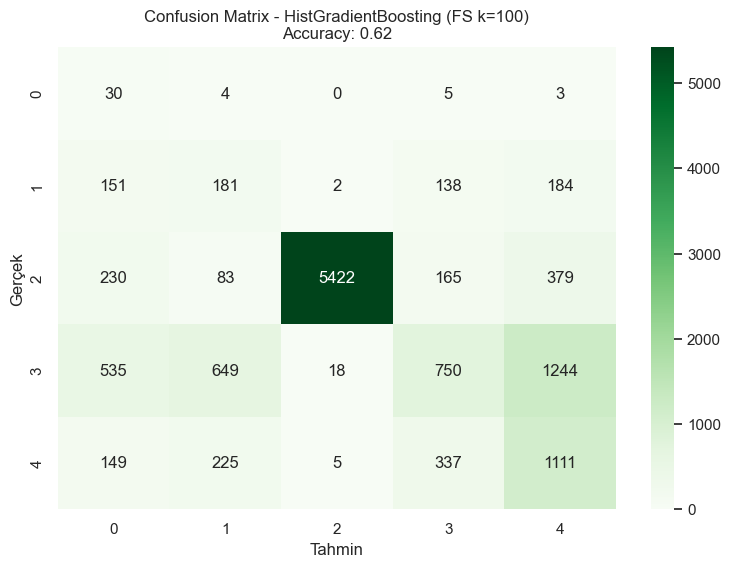

In [52]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================================================
# ADIM 3: HistGradientBoosting + Feature Selection pipeline
# =========================================================

hgb_clf = HistGradientBoostingClassifier(
    max_iter=200,        # ağaç sayısı 
    learning_rate=0.1,   # öğrenme hızı
    max_depth=None,      
    random_state=42
)

hgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selector),
    ('classifier', hgb_clf)
])

# --- class imbalance için sample_weight hesapla (train seti) ---
sample_w = compute_sample_weight(class_weight='balanced', y=y_train)

print("HistGradientBoosting eğitiliyor...")
hgb_pipeline.fit(X_train, y_train, classifier__sample_weight=sample_w)
print("Eğitim tamamlandı.")

# --- Validation tahmini ---
y_pred_hgb = hgb_pipeline.predict(X_val)
acc_hgb = accuracy_score(y_val, y_pred_hgb)

print("\n--- HistGradientBoosting Sonuçları (Validation) ---")
print(f"Accuracy: {acc_hgb:.4f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_val, y_pred_hgb))

# --- Confusion Matrix ---
plt.figure(figsize=(9, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_hgb), annot=True, fmt='d', cmap='Greens')
plt.title(f"Confusion Matrix - HistGradientBoosting (FS k={K_BEST})\nAccuracy: {acc_hgb:.2f}")
plt.ylabel("Gerçek")
plt.xlabel("Tahmin")
plt.show()


## 18- ExtraTrees ile Model Eğitimi 

Bu bölümde, **ExtraTreesClassifier** modeli; ortak ön işleme adımı ve
**SelectKBest (k=100)** özellik seçimi ile birlikte bir pipeline içerisinde
eğitilmiştir. Rastgeleleştirilmiş ağaç yapısı sayesinde modelin varyansı
azaltması ve karmaşık ilişkileri yakalayabilmesi hedeflenmiştir.

Sınıf dengesizliği problemi, modelin kendi yapısına entegre edilen
**class_weight='balanced'** parametresi ile ele alınmıştır.
Model performansı doğrulama seti üzerinde **accuracy**, **classification report**
ve **confusion matrix** kullanılarak değerlendirilmiştir.


ExtraTrees eğitiliyor...
Eğitim tamamlandı.

--- ExtraTrees Sonuçları (Validation) ---
Accuracy: 0.6647

Sınıflandırma Raporu:
                          precision    recall  f1-score   support

                   FATAL       0.02      0.14      0.04        42
   INCAPACITATING INJURY       0.15      0.26      0.19       656
 NO INDICATION OF INJURY       0.99      0.87      0.93      6279
NONINCAPACITATING INJURY       0.52      0.45      0.48      3196
   REPORTED, NOT EVIDENT       0.39      0.50      0.44      1827

                accuracy                           0.66     12000
               macro avg       0.42      0.44      0.42     12000
            weighted avg       0.73      0.66      0.69     12000



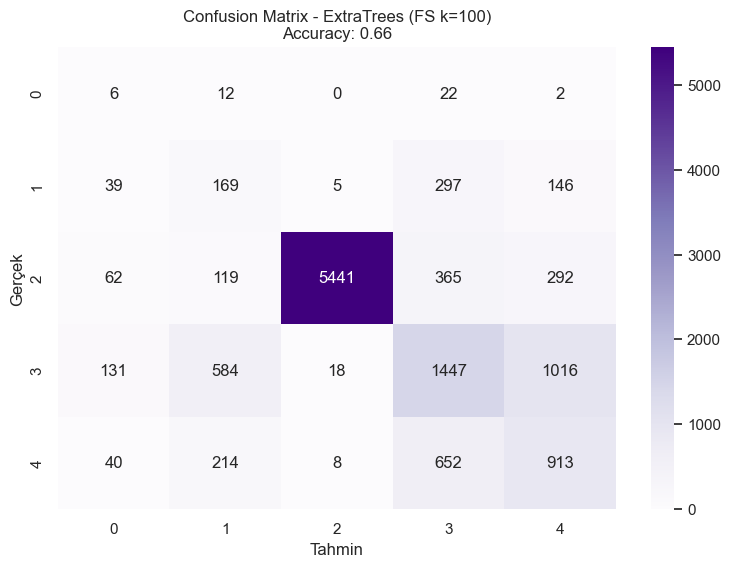

In [53]:
from sklearn.ensemble import ExtraTreesClassifier

# =========================================================
# ADIM 4: ExtraTrees + Feature Selection pipeline
# =========================================================

et_clf = ExtraTreesClassifier(
    n_estimators=200,        # ağaç sayısı 
    max_depth=None,         
    min_samples_leaf=2,      # biraz genelleme, overfit azaltır
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'  # dengesiz sınıflar için
)

et_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=K_BEST)),  # selector'ı ayrı kullanalım
    ('classifier', et_clf)
])

print("ExtraTrees eğitiliyor...")
et_pipeline.fit(X_train, y_train)
print("Eğitim tamamlandı.")

# --- Validation tahmini ---
y_pred_et = et_pipeline.predict(X_val)
acc_et = accuracy_score(y_val, y_pred_et)

print("\n--- ExtraTrees Sonuçları (Validation) ---")
print(f"Accuracy: {acc_et:.4f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_val, y_pred_et))

# --- Confusion Matrix ---
plt.figure(figsize=(9, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_et), annot=True, fmt='d', cmap='Purples')
plt.title(f"Confusion Matrix - ExtraTrees (FS k={K_BEST})\nAccuracy: {acc_et:.2f}")
plt.ylabel("Gerçek")
plt.xlabel("Tahmin")
plt.show()


## 19- Modellerin Doğrulama Performanslarının Karşılaştırılması

Bu bölümde, **HistGradientBoosting** ve **ExtraTrees** modellerinin doğrulama
(verification) seti üzerindeki **accuracy** değerleri basit bir kıyas tablosu
halinde sunulmuştur. Bu karşılaştırma, kullanılan ortak ön işleme ve özellik
seçimi adımlarının ardından modellerin genel performans eğilimlerini
gözlemlemek amacıyla yapılmıştır.


In [54]:
import pandas as pd

# =========================================================
# ADIM 5: Basit kıyas tablosu (Validation Accuracy)
# =========================================================
results_df = pd.DataFrame({
    "Model": ["HistGradientBoosting (FS)", "ExtraTrees (FS)"],
    "Val_Accuracy": [acc_hgb, acc_et]
}).sort_values(by="Val_Accuracy", ascending=False)

print(results_df)


                       Model  Val_Accuracy
1            ExtraTrees (FS)      0.664667
0  HistGradientBoosting (FS)      0.624500


## 20- Seçilen Model (ExtraTrees) ile Test Seti Değerlendirmesi

Bu bölümde, doğrulama sonuçlarına göre seçilen **ExtraTrees** modeli,
daha önce hiç görülmemiş **test seti** üzerinde değerlendirilmiştir.
Modelin genelleme başarısı **accuracy**, **classification report**
ve **confusion matrix** üzerinden analiz edilmiştir.



--- ExtraTrees (FS) TEST Set Sonuçları ---
Test Accuracy: 0.6617

Sınıflandırma Raporu:
                          precision    recall  f1-score   support

                   FATAL       0.02      0.17      0.04       212
   INCAPACITATING INJURY       0.14      0.23      0.18      3282
 NO INDICATION OF INJURY       0.99      0.86      0.92     31395
NONINCAPACITATING INJURY       0.52      0.46      0.49     15977
   REPORTED, NOT EVIDENT       0.39      0.51      0.44      9131

                accuracy                           0.66     59997
               macro avg       0.41      0.44      0.41     59997
            weighted avg       0.73      0.66      0.69     59997



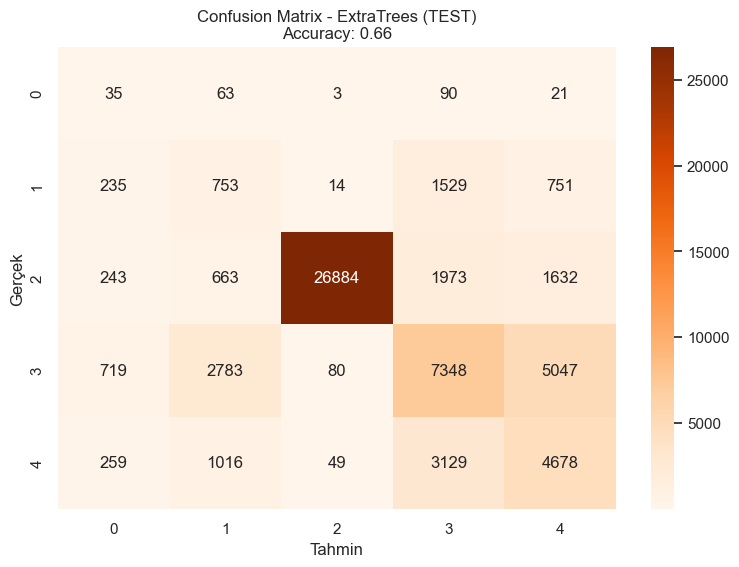

In [55]:
# =========================================================
# ADIM 2: Seçilen model (ExtraTrees) ile TEST seti değerlendirmesi
# =========================================================

print("\n--- ExtraTrees (FS) TEST Set Sonuçları ---")

y_test_pred = et_pipeline.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_acc:.4f}")
print("\nSınıflandırma Raporu:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix (TEST)
plt.figure(figsize=(9, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Oranges')
plt.title(f"Confusion Matrix - ExtraTrees (TEST)\nAccuracy: {test_acc:.2f}")
plt.ylabel("Gerçek")
plt.xlabel("Tahmin")
plt.show()


In [56]:
# =========================================================
# ADIM 1: Windows joblib/loky (wmic) hatasını engelle
# =========================================================
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "1"  # paralelliği güvenli şekilde sınırlar


## 21- ExtraTrees Modeli için Hafif Hiperparametre Optimizasyonu

Bu bölümde, seçilen **ExtraTrees** modeli için sınırlı ve hızlı bir
hiperparametre optimizasyonu gerçekleştirilmiştir. **RandomizedSearchCV**
kullanılarak ağaç sayısı, derinlik ve yaprak parametreleri gibi temel
hiperparametreler dar bir aralıkta denenmiştir.

Değerlendirme metriği olarak, sınıf dengesizliğini daha iyi yansıtması
nedeniyle **f1_macro** tercih edilmiştir. Amaç, aşırı maliyetli bir arama
sürecine girmeden model performansını iyileştirebilecek uygun parametre
kombinasyonlarını belirlemektir.


In [57]:
# =========================================================
# ADIM 2: ExtraTrees (FS) için hafif Hyperparameter Tuning
# =========================================================

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Pipeline ---

K_BEST = 100

et_tune_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=K_BEST)),
    ('classifier', ExtraTreesClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=1   
    ))
])




In [58]:
# --- Denenecek hiperparametre aralıkları ---
param_dist = {
    'classifier__n_estimators': [150, 200, 300],      # ağaç sayısı
    'classifier__max_depth': [None, 20, 30, 40],      # ağaç derinliği
    'classifier__min_samples_leaf': [1, 2, 4],        # yaprak minimum örnek
    'classifier__max_features': ['sqrt', 'log2', 0.5] # her splitte kullanılacak özellik oranı
}

# --- RandomizedSearch: az deneme, hızlı ---
search = RandomizedSearchCV(
    estimator=et_tune_pipeline,
    param_distributions=param_dist,
    n_iter=6,                 # 5–8 arası idealdir 
    scoring='f1_macro',       # dengesiz sınıflar için accuracy'den daha anlamlı
    cv=3,                     # 3-fold yeterli 
    random_state=42,
    n_jobs=1,                 
    verbose=2
)

In [59]:


print("Tuning başlıyor (RandomizedSearchCV)...")
search.fit(X_train, y_train)
print("Tuning bitti ")

print("\n--- En iyi skor (CV f1_macro) ---")
print(search.best_score_)

print("\n--- En iyi parametreler ---")
print(search.best_params_)


Tuning başlıyor (RandomizedSearchCV)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time=11.0min
[CV] END classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time=12.8min
[CV] END classifier__max_depth=30, classifier__max_features=0.5, classifier__min_samples_leaf=2, classifier__n_estimators=300; total time=13.8min
[CV] END classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time= 3.7min
[CV] END classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time= 3.6min
[CV] END classifier__max_depth=None, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__n_estimators=200; total time= 3.5min
[CV] END classi

## 22- Optimize Edilmiş ExtraTrees Modelinin Validation ve Test Performansı

Bu bölümde, hiperparametre optimizasyonu sonucunda elde edilen
**en iyi ExtraTrees modeli**, hem doğrulama (validation) hem de test
setleri üzerinde değerlendirilmiştir. Modelin genelleme başarısı,
**accuracy**, **classification report** ve **confusion matrix**
üzerinden karşılaştırmalı olarak incelenmiştir.



=== TUNED ExtraTrees (FS) - VALIDATION ===
Validation Accuracy: 0.6647
                          precision    recall  f1-score   support

                   FATAL       0.02      0.14      0.04        42
   INCAPACITATING INJURY       0.15      0.26      0.19       656
 NO INDICATION OF INJURY       0.99      0.87      0.93      6279
NONINCAPACITATING INJURY       0.52      0.45      0.48      3196
   REPORTED, NOT EVIDENT       0.39      0.50      0.44      1827

                accuracy                           0.66     12000
               macro avg       0.42      0.44      0.42     12000
            weighted avg       0.73      0.66      0.69     12000



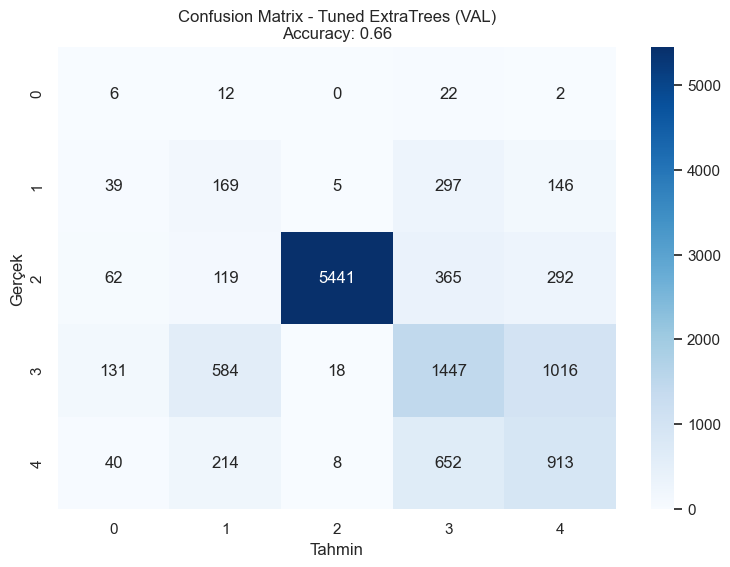


=== TUNED ExtraTrees (FS) - TEST ===
Test Accuracy: 0.6617
                          precision    recall  f1-score   support

                   FATAL       0.02      0.17      0.04       212
   INCAPACITATING INJURY       0.14      0.23      0.18      3282
 NO INDICATION OF INJURY       0.99      0.86      0.92     31395
NONINCAPACITATING INJURY       0.52      0.46      0.49     15977
   REPORTED, NOT EVIDENT       0.39      0.51      0.44      9131

                accuracy                           0.66     59997
               macro avg       0.41      0.44      0.41     59997
            weighted avg       0.73      0.66      0.69     59997



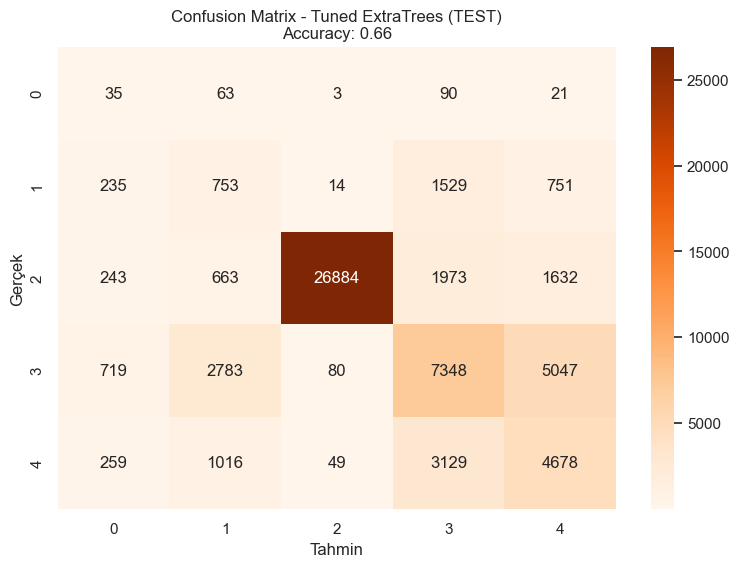

In [60]:
# =========================================================
# ADIM 3: En iyi model ile Validation + Test değerlendirme
# =========================================================

best_model = search.best_estimator_

# --- Validation ---
y_val_pred_tuned = best_model.predict(X_val)
val_acc_tuned = accuracy_score(y_val, y_val_pred_tuned)

print("\n=== TUNED ExtraTrees (FS) - VALIDATION ===")
print(f"Validation Accuracy: {val_acc_tuned:.4f}")
print(classification_report(y_val, y_val_pred_tuned))

plt.figure(figsize=(9, 6))
sns.heatmap(confusion_matrix(y_val, y_val_pred_tuned), annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix - Tuned ExtraTrees (VAL)\nAccuracy: {val_acc_tuned:.2f}")
plt.ylabel("Gerçek")
plt.xlabel("Tahmin")
plt.show()

# --- Test ---
y_test_pred_tuned = best_model.predict(X_test)
test_acc_tuned = accuracy_score(y_test, y_test_pred_tuned)

print("\n=== TUNED ExtraTrees (FS) - TEST ===")
print(f"Test Accuracy: {test_acc_tuned:.4f}")
print(classification_report(y_test, y_test_pred_tuned))

plt.figure(figsize=(9, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred_tuned), annot=True, fmt='d', cmap='Oranges')
plt.title(f"Confusion Matrix - Tuned ExtraTrees (TEST)\nAccuracy: {test_acc_tuned:.2f}")
plt.ylabel("Gerçek")
plt.xlabel("Tahmin")
plt.show()


## 23- Hiperparametre Optimizasyonu Öncesi ve Sonrası Performans Karşılaştırması

Bu bölümde, **ExtraTrees** modelinin hiperparametre optimizasyonu
öncesi ve sonrası performansı karşılaştırılmıştır. Değerlendirme,
test seti üzerinde **accuracy**, **macro F1** ve **weighted F1**
metrikleri kullanılarak gerçekleştirilmiştir.

Bu karşılaştırma, optimizasyon sürecinin modelin sınıf bazlı başarısı
ve genel genelleme performansı üzerindeki etkisini daha net biçimde
gözlemlemek amacıyla yapılmıştır.


In [61]:
# =========================================================
# ADIM 4: Tuning öncesi / sonrası kıyas 
# =========================================================

print("\n--- ÖZET KARŞILAŞTIRMA ---")
print(f"Önce (Test Accuracy):  {test_acc:.4f}")
print(f"Sonra (Test Accuracy): {test_acc_tuned:.4f}")



--- ÖZET KARŞILAŞTIRMA ---
Önce (Test Accuracy):  0.6617
Sonra (Test Accuracy): 0.6617


In [62]:
from sklearn.metrics import f1_score

# =========================================================
# ADIM 1: F1 skorlarının hesaplanması (TEST SET)
# =========================================================

# --- Tuning ÖNCESİ ---
f1_macro_before = f1_score(y_test, y_test_pred, average='macro')
f1_weighted_before = f1_score(y_test, y_test_pred, average='weighted')

# --- Tuning SONRASI ---
f1_macro_after = f1_score(y_test, y_test_pred_tuned, average='macro')
f1_weighted_after = f1_score(y_test, y_test_pred_tuned, average='weighted')

print("=== F1 KARŞILAŞTIRMASI (TEST SET) ===")
print(f"ÖNCE  - Macro F1   : {f1_macro_before:.4f}")
print(f"SONRA - Macro F1   : {f1_macro_after:.4f}")
print()
print(f"ÖNCE  - Weighted F1: {f1_weighted_before:.4f}")
print(f"SONRA - Weighted F1: {f1_weighted_after:.4f}")


=== F1 KARŞILAŞTIRMASI (TEST SET) ===
ÖNCE  - Macro F1   : 0.4133
SONRA - Macro F1   : 0.4133

ÖNCE  - Weighted F1: 0.6886
SONRA - Weighted F1: 0.6886


In [63]:
import pandas as pd

# =========================================================
# ADIM 2: Tablo halinde karşılaştırma
# =========================================================

f1_compare_df = pd.DataFrame({
    "Metric": ["Macro F1", "Weighted F1"],
    "Tuning Öncesi": [f1_macro_before, f1_weighted_before],
    "Tuning Sonrası": [f1_macro_after, f1_weighted_after]
})

print(f1_compare_df)


        Metric  Tuning Öncesi  Tuning Sonrası
0     Macro F1       0.413304        0.413304
1  Weighted F1       0.688561        0.688561
